In [40]:
from keras import backend as K
import numpy as np
from keras.datasets import mnist
from keras.layers import MaxPooling2D
import math
import matplotlib.pyplot as plt
%matplotlib inline 
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, Activation
from keras import applications
import skimage

Train on 60000 samples, validate on 10000 samples
Epoch 1/3
60000/60000 [==============================] - 16s 259us/step - loss: 2.0651 - acc: 0.8418 - val_loss: 0.0793 - val_acc: 0.9738
Epoch 2/3
60000/60000 [==============================] - 10s 162us/step - loss: 0.0718 - acc: 0.9786 - val_loss: 0.0600 - val_acc: 0.9813
Epoch 3/3
60000/60000 [==============================] - 10s 163us/step - loss: 0.0565 - acc: 0.9825 - val_loss: 0.0488 - val_acc: 0.9852


array([[0., 0., 0., 0., 0., 0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
       [1., 0., 0., 0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

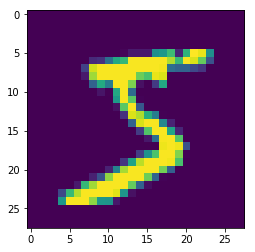

In [2]:

#download mnist data and split into train and test sets
(X_train, y_train), (X_test, y_test) = mnist.load_data()


#plot the first image in the dataset
plt.imshow(X_train[0])

X_train[0].shape

X_train = X_train.reshape(60000,28,28,1)
X_test = X_test.reshape(10000,28,28,1)


#one-hot encode target column
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)
y_train[0]


#create model
model = Sequential()
#add model layers
model.add(Conv2D(64, (3,3), activation='relu', input_shape=(28,28,1), name='conv1'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(32, (3,3), activation='relu', name='conv2'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=3)

model.predict(X_test[:4])
y_test[:4]

In [42]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 24, 24, 64)        1664      
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 8, 8, 32)          51232     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 4, 4, 32)          0         
_________________________________________________________________
flatten_5 (Flatten)          (None, 512)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 10)                5130      
_________________________________________________________________
activation_1 (Activation)    (None, 10)                0         
Total para

In [6]:
# Visualize the activation maps of filters from conv1 and conv2.
# The output of all layers
inp=model.input
outputs = [layer.output for layer in model.layers]
functor = K.function([inp, K.learning_phase()], outputs )


In [50]:
# Pass the first image in training set to the model, and get the outputs of all 6 layers.
test = X_train[0][np.newaxis,...]
layer_outs = functor([test, 0.])


In [48]:
type(layer_outs)
len(layer_outs)
np.shape(layer_outs[0][0,:,:,:])

(24, 24, 64)

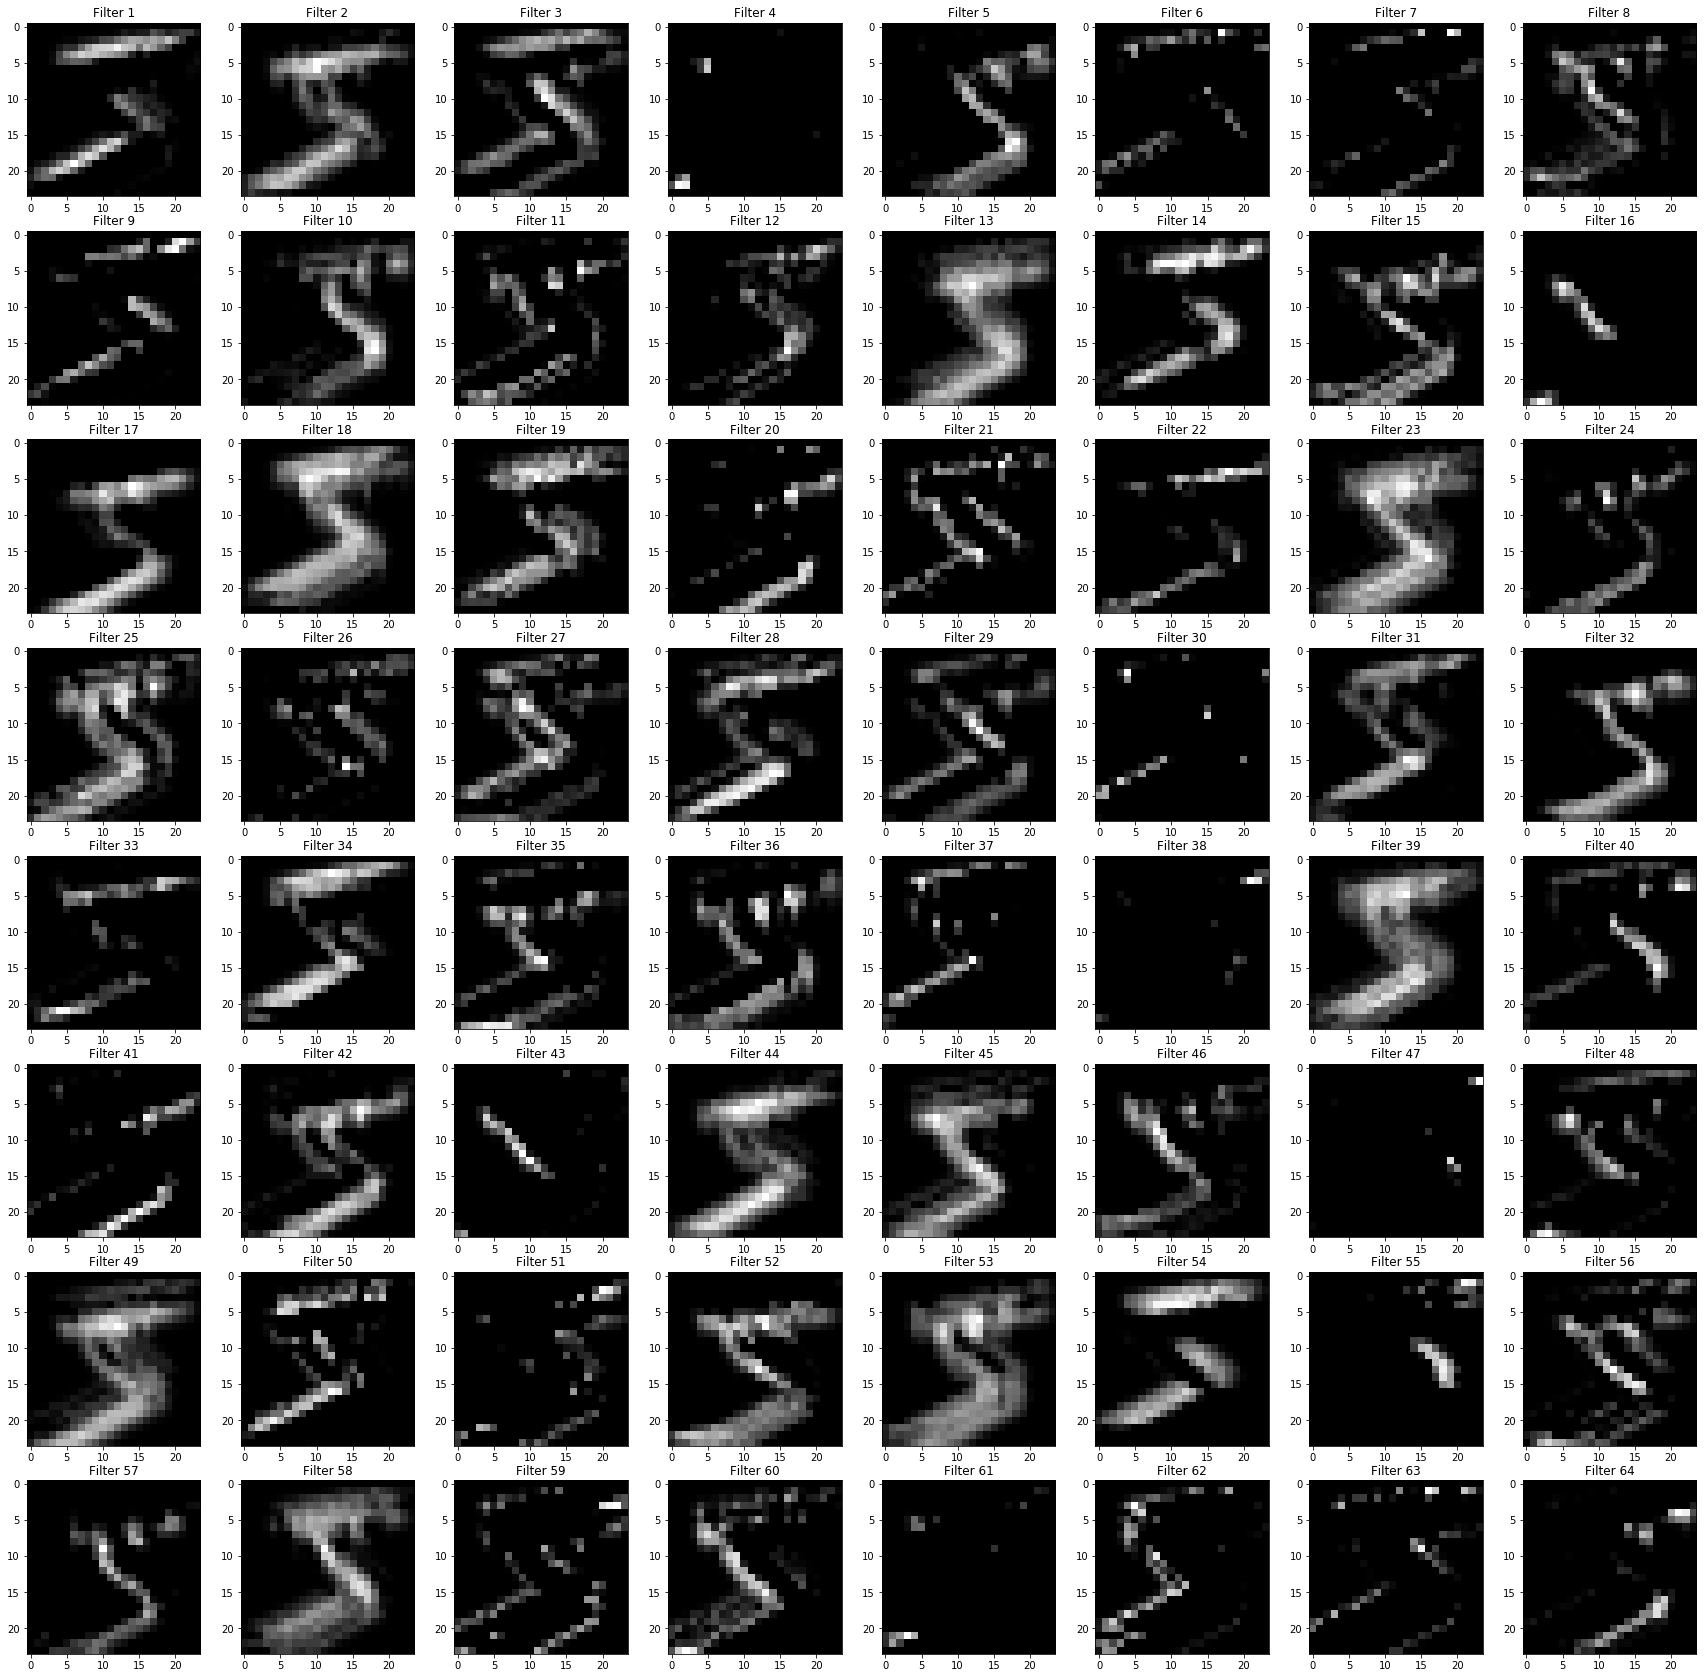

In [23]:
# The activation map given by the 64 filters in conv1. 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(layer_outs[0][0,:,:,i],cmap='gray')

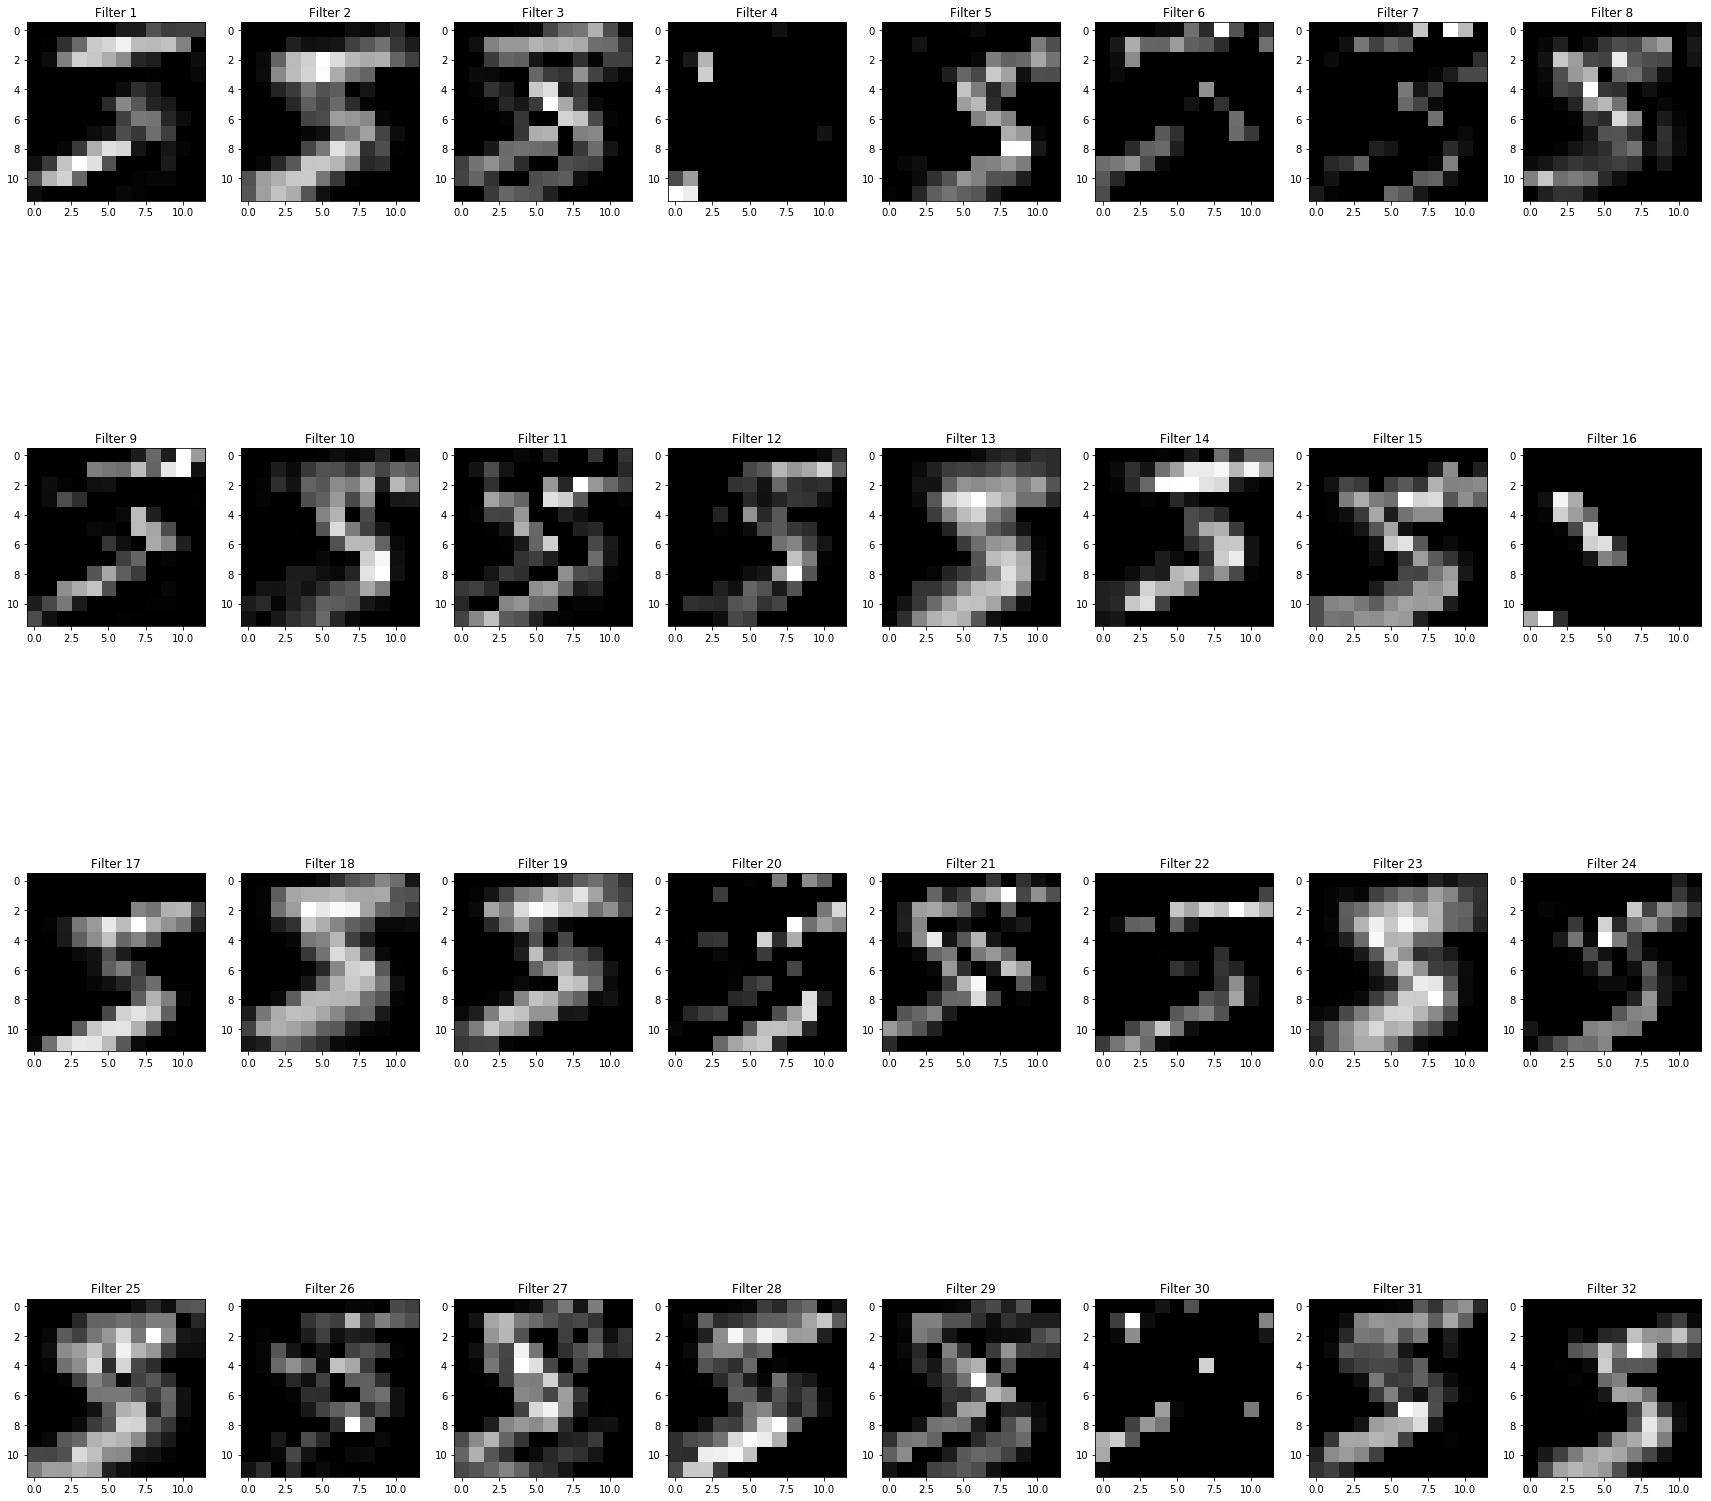

In [24]:
# The activation map given by the 64 filters in conv2. 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(layer_outs[1][0,:,:,i],cmap='gray')

In [27]:
input_img = model.input  # Placeholder

In [26]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[0:]])  # Help us index different layers in the following steps.

In [28]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())  

# The idea of normalizing gradient is from the post "How convolutional neural networks see the world".

In [29]:
def deprocess_image(x):
    # normalize tensor
    x -= x.mean()
    x /= (x.std() + K.epsilon())  # This function is from the post "How convolutional neural networks see the world".
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)  # Limits the value of every pixel between 0 and 1
    return x

In [8]:
a = model.get_weights()
firstlayer = []
for i in range(64):
    firstlayer.append(a[0][:,:,0,i])


In [9]:
# Neruon
# Find an input image that maximaly activate the 64 filters in conv1.
kept_filters = []
idx = 1
for Filter in firstlayer:
    l1f1_in_tmp = []
    for row in Filter:
        row_tmp = []
        for entry in row:
            if entry >=0:
                row_tmp.append(1)
            else:
                row_tmp.append(0)
        l1f1_in_tmp.append(row_tmp)
    idx = idx+1

    kept_filters.append((l1f1_in_tmp, idx))

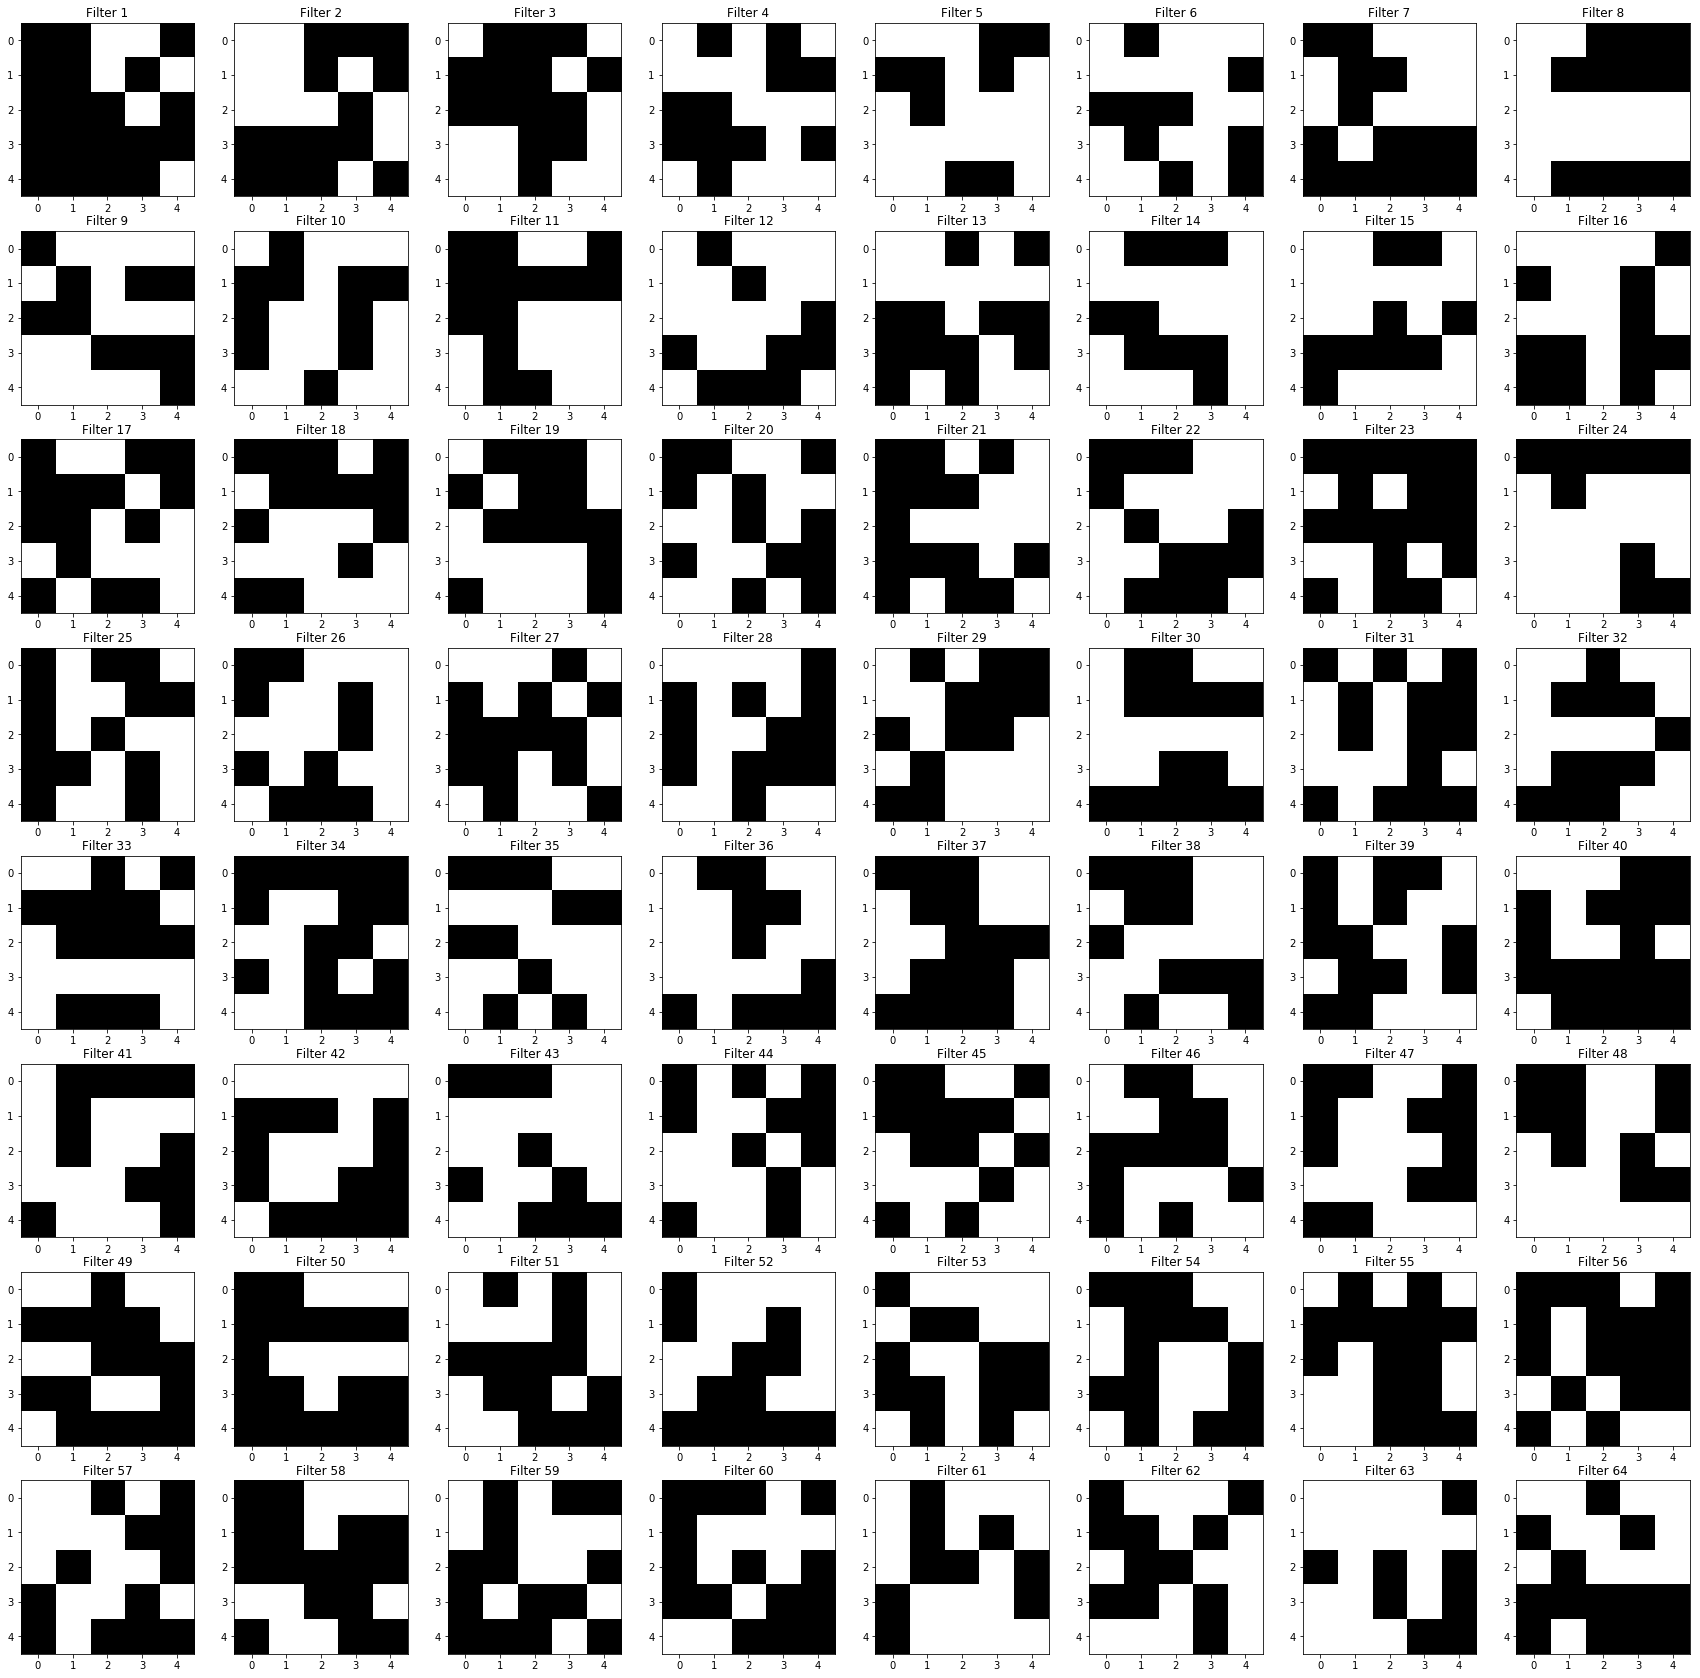

In [10]:
# Show the 64 images 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters[i][0],cmap='gray')

In [11]:
# Find input images that maximaly activate the filters in conv1.
kept_filters = []
for filter_index in range(64):
    
    layer_output = layer_dict['conv1'].output
    loss = K.sum(layer_output[:, :, :, filter_index])  #We had a hard time to realize tha idea, "maximize activation". 
    # It was the artical "How convolutional neural networks see the world" inspired us. 
    # And the method is from the article.
    
    # The gradient of the loss with respect to input image.
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads, when the input picture is given
    iterate = K.function([input_img], [loss, grads])  # This beckend function is also from the article 
    # "How convolutional neural network see the world"
    
    step = 0.2

    # we start from some random noise
    input_img_data = np.random.random((1, 28, 28, 1))
    
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        if loss_value <= 0.:
            break
    
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))

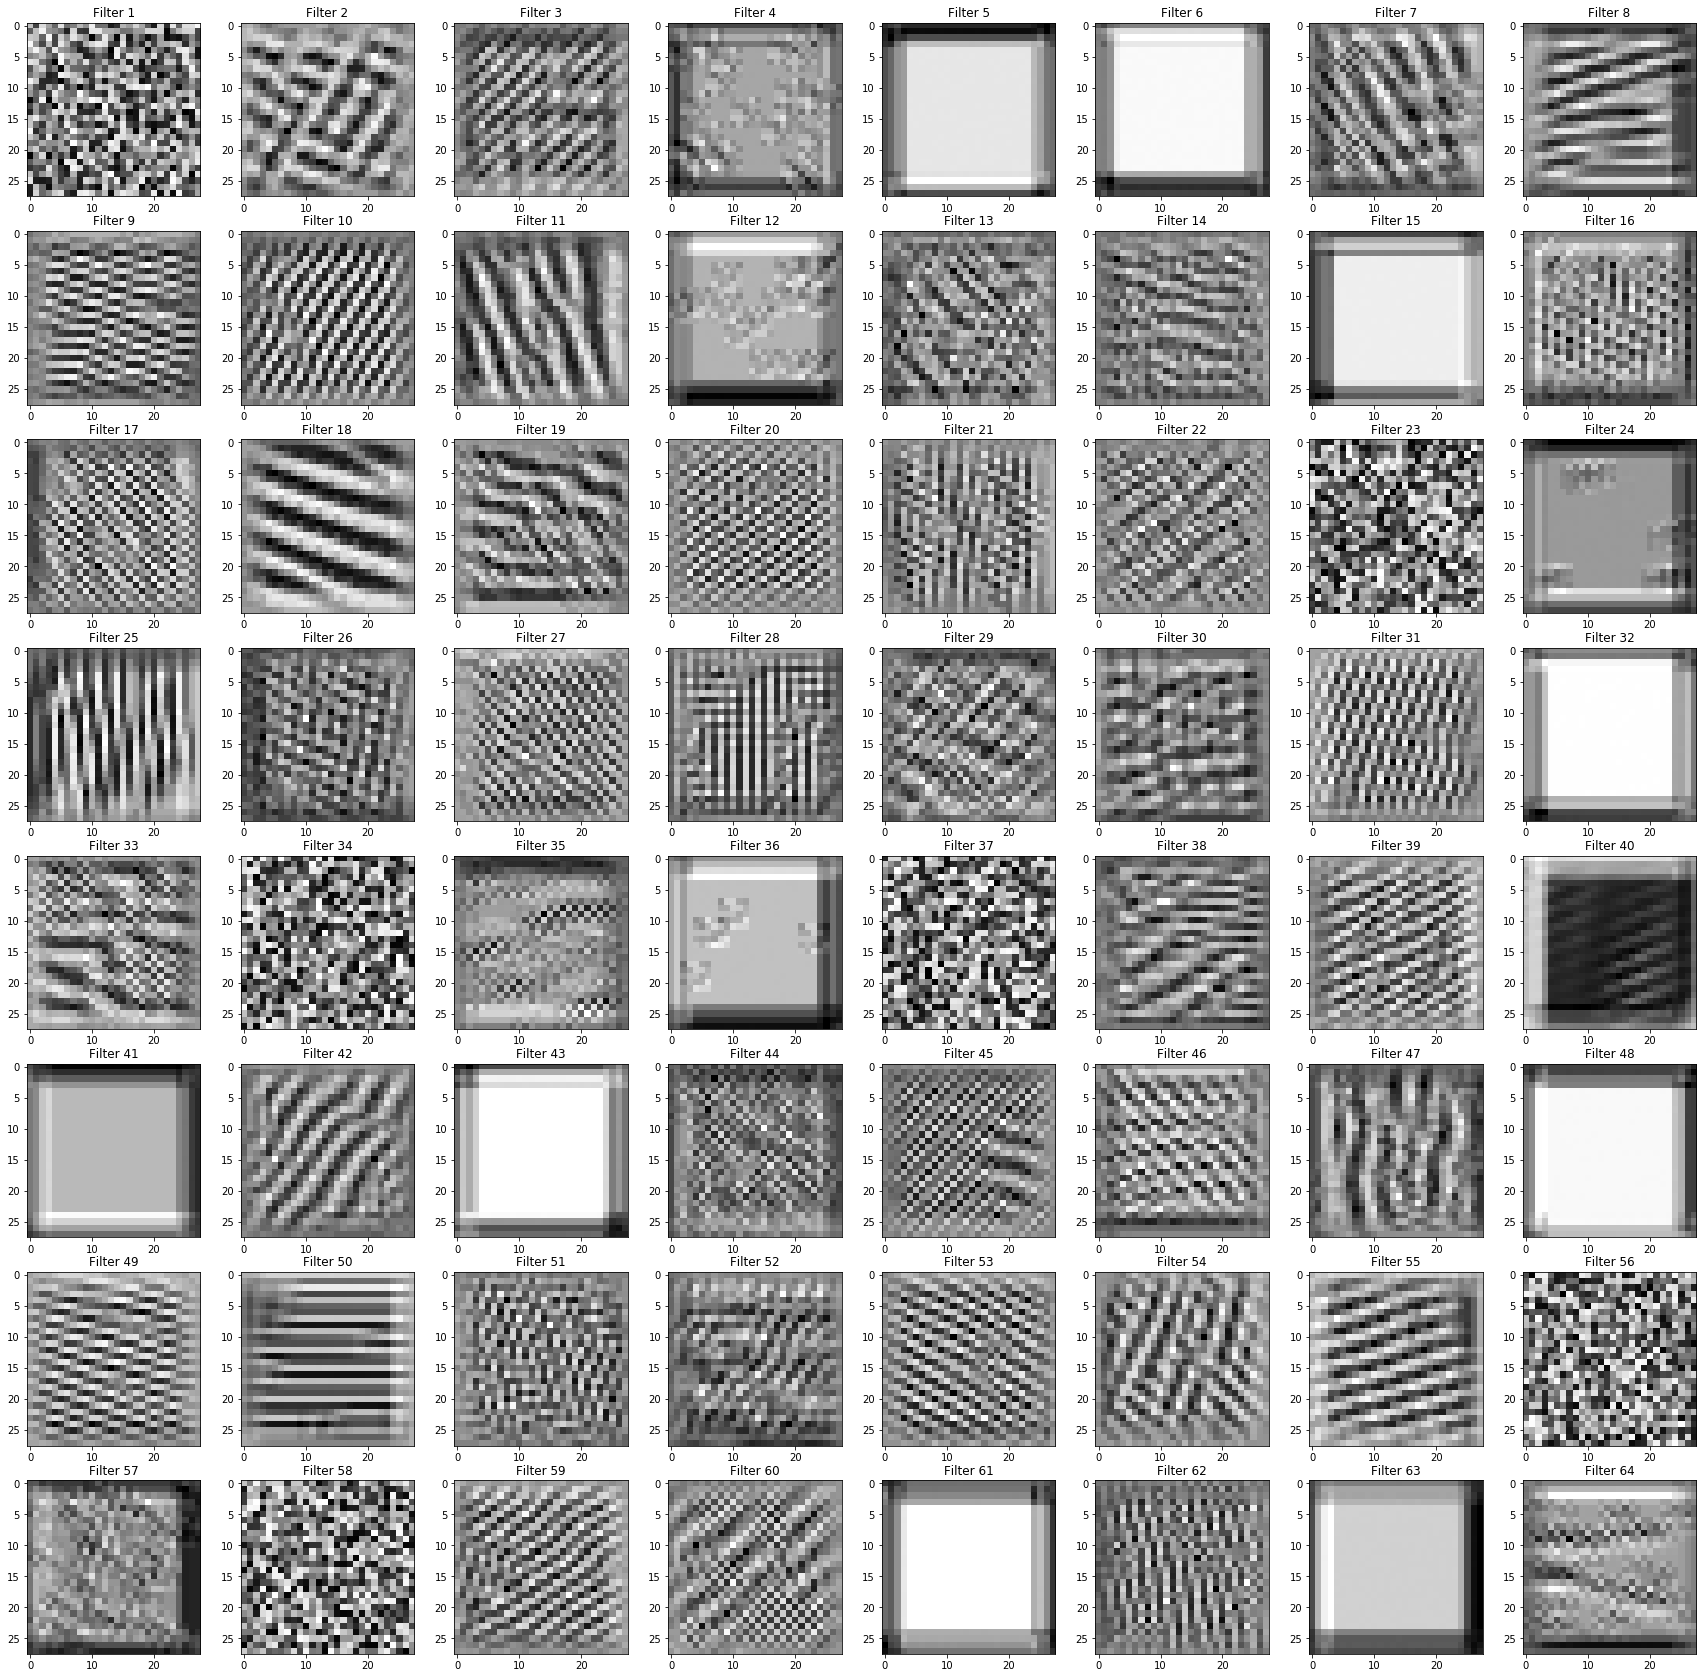

In [12]:
# Show the 64 images 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters[i][0][:,:,0].reshape(28,28),cmap='gray')

In [15]:
# Regularization
# Find input images that maximaly activate the filters in conv1.
kept_filters = []
for filter_index in range(64):

    layer_output = layer_dict['conv1'].output
    loss = K.sum(layer_output[:, :, :, filter_index])  #We had a hard time to realize tha idea, "maximize activation". 
    # It was the artical "How convolutional neural networks see the world" inspired us. 
    # And the method is from the article.
    
    # The gradient of the loss with respect to input image.
    grads = K.gradients(loss, input_img)[0]

    # normalization trick: we normalize the gradient
    grads = normalize(grads)

    # this function returns the loss and grads, when the input picture is given
    iterate = K.function([input_img], [loss, grads])  # This beckend function is also from the article 
    # "How convolutional neural network see the world"
    

    # step size for gradient ascent
    step = 0.25

    # we start from a image with some random noise
    input_img_data = np.random.random((1, 28, 28, 1))
    #input_img_data = (input_img_data - 0.5) * 20 + 128
    
    # we run gradient ascent for 20 steps
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])

        
        input_img_data += grads_value * step
        
        input_img_data = input_img_data.reshape(28,28)
        for row in input_img_data:
            for item in row:
                factor = np.random.uniform(-1,1)
                item = item + factor * 0.5
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rotate(input_img_data,factor*0.05)
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rescale(input_img_data,1.01**factor)
        input_img_data = skimage.transform.resize(input_img_data,(28,28))
        input_img_data = input_img_data.reshape(1,28,28,1)
        

        if loss_value <= 0.:
           
            break
     
    
    img = deprocess_image(input_img_data[0])
    kept_filters.append((img, loss_value))
    

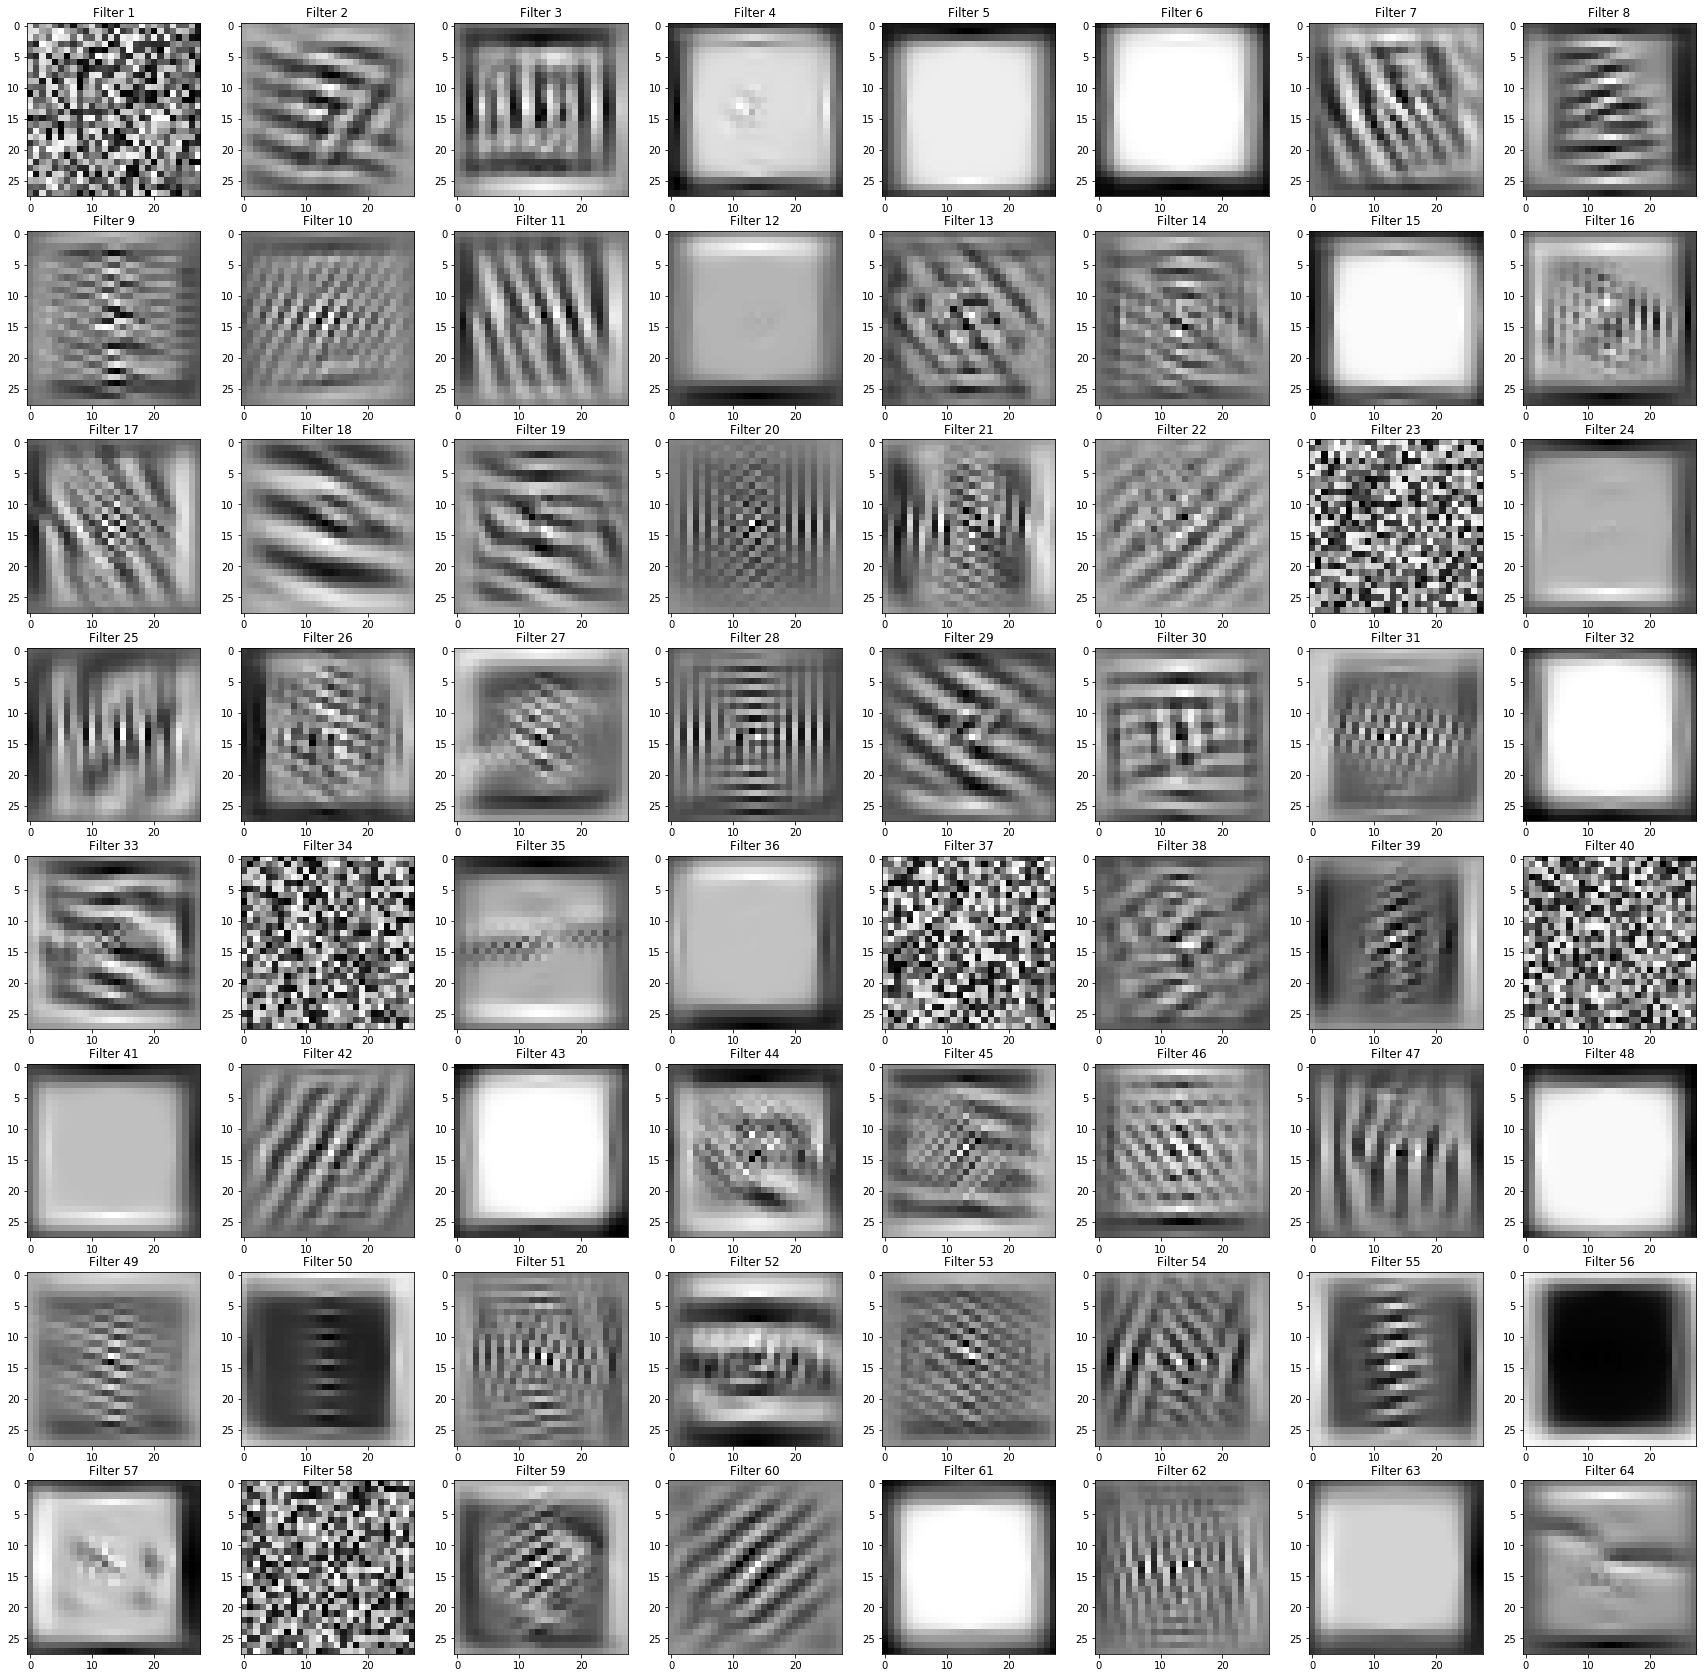

In [14]:
# Show the 64 images 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters[i][0][:,:,0].reshape(28,28),cmap='gray')

In [15]:
secondlayer = []
for i in range(32):
    secondlayer.append(a[2][:,:,0,i])

In [16]:
# Find input images that maximaly activate the filters in conv2.
kept_filters = []
idx = 1
for Filter in secondlayer:
    l1f1_in_tmp = []
    for row in Filter:
        row_tmp = []
        for entry in row:
            if entry >=0:
                row_tmp.append(1)
            else:
                row_tmp.append(0)
        l1f1_in_tmp.append(row_tmp)
    idx = idx+1

    kept_filters.append((l1f1_in_tmp, idx))

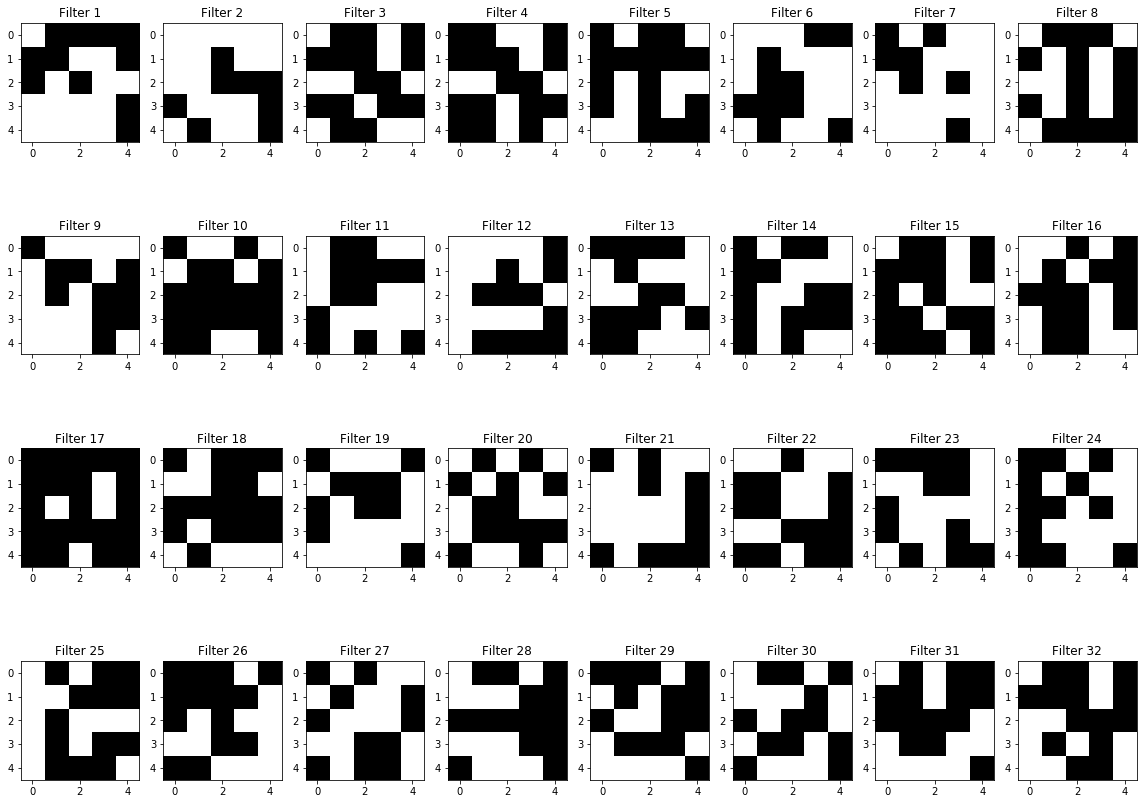

In [17]:
# Show the 32 images 
plt.figure(1, figsize=(20,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters[i][0],cmap='gray')

In [18]:
# Find input images that maximaly activate the filters in conv2.
kept_filters_2 = []
for filter_index in range(32):
   
    layer_output = layer_dict['conv2'].output
    loss = K.sum(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, input_img)[0]
    grads = normalize(grads)

    iterate = K.function([input_img], [loss, grads])
    step = 0.2

    input_img_data = np.random.random((1, 28, 28, 1))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        if loss_value <= 0.:
            break
    
    img = deprocess_image(input_img_data[0])
    kept_filters_2.append((img, loss_value))

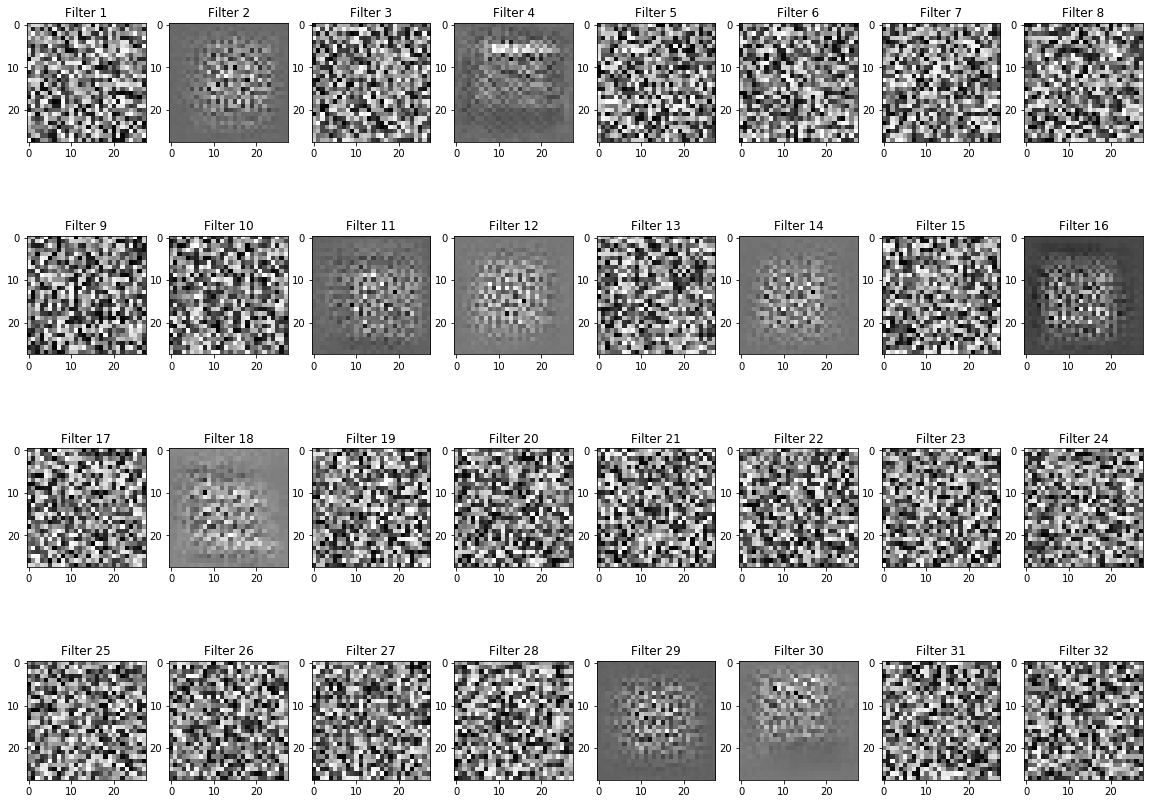

In [19]:
# Show the 32 images 
plt.figure(1, figsize=(20,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters_2[i][0][:,:,0].reshape(28,28),cmap='gray')

In [20]:
# Regularization
# Find input images that maximaly activate the filters in conv2.
kept_filters_2 = []
for filter_index in range(32):
    
    layer_output = layer_dict['conv2'].output
    loss = K.sum(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, input_img)[0]
    grads = normalize(grads)
    iterate = K.function([input_img], [loss, grads])
    
    step = 0.2

    input_img_data = np.random.random((1, 28, 28, 1))
    input_img_data = (input_img_data - 0.5) * 20 + 128
    
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        input_img_data = input_img_data.reshape(28,28)
        for row in input_img_data:
            for item in row:
                factor = np.random.uniform(-1,1)
                item = item + factor * 0.5
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rotate(input_img_data,factor*0.1)
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rescale(input_img_data,1.01**factor)
        input_img_data = skimage.transform.resize(input_img_data,(28,28))
        input_img_data = input_img_data.reshape(1,28,28,1)
        
        if loss_value <= 0.:
            break
    
    img = deprocess_image(input_img_data[0])
    kept_filters_2.append((img, loss_value))

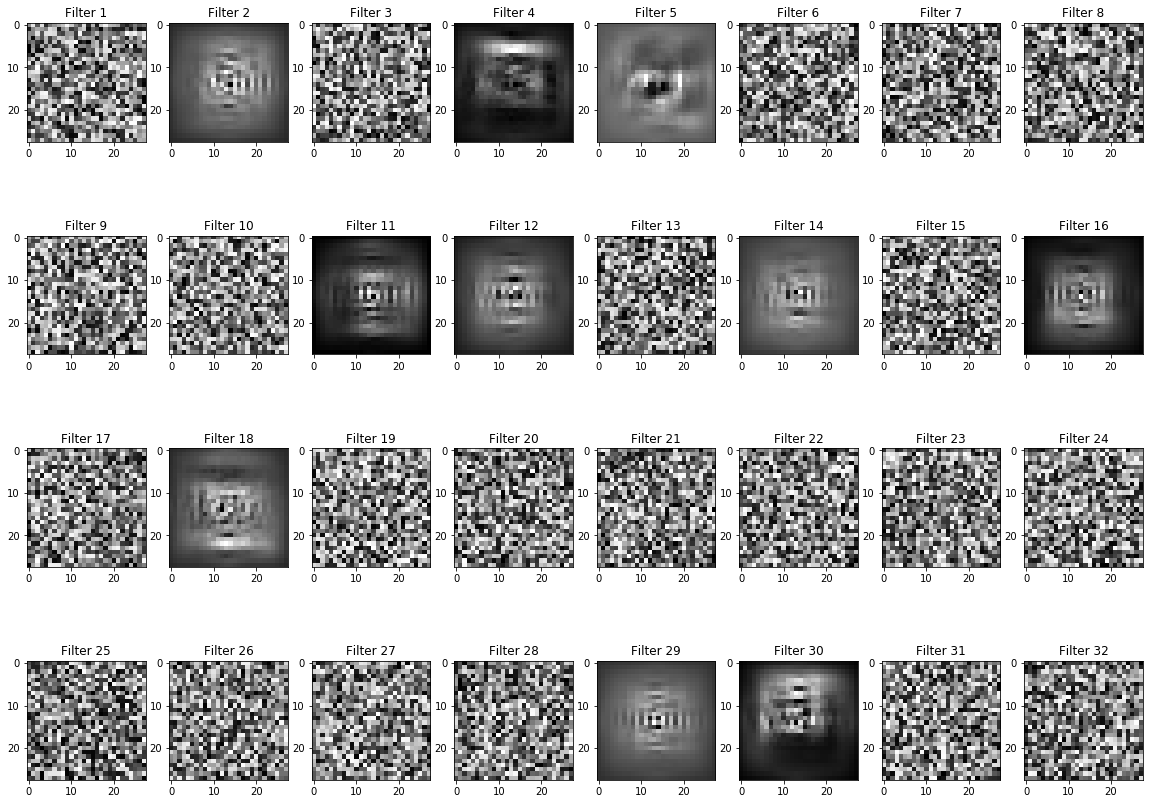

In [21]:
# Show the 64 images 
plt.figure(1, figsize=(20,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters_2[i][0][:,:,0].reshape(28,28),cmap='gray')

In [17]:
# SVHN
from __future__ import absolute_import
from __future__ import print_function

import numpy as np
import scipy.io

import keras
from keras.models import Sequential

from keras.layers import Dense, Dropout, Activation,Flatten
from keras.layers.convolutional import Convolution2D, MaxPooling2D

In [18]:
batch_size = 128
nb_classes = 10
nb_epoch = 20
Train = scipy.io.loadmat('train_32x32.mat') 
Test = scipy.io.loadmat('test_32x32.mat') 

X_train = Train['X']
y_train = Train['y']
X_test = Test['X']
y_test = Test['y']

X_train = X_train.astype('float32')
X_test = X_test.astype('float32')
X_train /= 255
X_test /= 255

X_train = X_train[np.newaxis,...]
X_train = np.swapaxes(X_train,0,4).squeeze()

X_test = X_test[np.newaxis,...]
X_test = np.swapaxes(X_test,0,4).squeeze()


np.place(y_train,y_train == 10,0)
np.place(y_test,y_test == 10,0)

y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)


model = Sequential()

model.add(Convolution2D(32, 3, 3, border_mode='same',
                        input_shape=(32, 32, 3)))
model.add(Activation('relu'))
model.add(Convolution2D(32, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Convolution2D(64, 3, 3, border_mode='same'))
model.add(Activation('relu'))
model.add(Convolution2D(64, 3, 3))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(nb_classes))
model.add(Activation('softmax'))


sgd = keras.optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model.compile(loss='categorical_crossentropy', optimizer=sgd,metrics=['accuracy'])

model.fit(X_train, y_train, batch_size=batch_size, nb_epoch=nb_epoch, verbose=1, validation_data=(X_test, y_test))
score = model.evaluate(X_test, y_test, verbose=0)

c:\users\chenghao yu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:34: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), input_shape=(32, 32, 3..., padding="same")`
c:\users\chenghao yu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:36: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3))`
c:\users\chenghao yu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:40: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same")`
c:\users\chenghao yu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:42: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3))`
c:\users\chenghao yu\appdata\local\programs\python\python36\lib\site-packages\ipykernel_launcher.py:57: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.


Train on 73257 samples, validate on 26032 samples
Epoch 1/20
73257/73257 [==============================] - 13s 180us/step - loss: 2.2393 - acc: 0.1882 - val_loss: 2.2187 - val_acc: 0.1959
Epoch 2/20
73257/73257 [==============================] - 12s 165us/step - loss: 1.5141 - acc: 0.4846 - val_loss: 0.6812 - val_acc: 0.7934
Epoch 3/20
73257/73257 [==============================] - 12s 166us/step - loss: 0.6219 - acc: 0.8076 - val_loss: 0.4947 - val_acc: 0.8548
Epoch 4/20
73257/73257 [==============================] - 12s 165us/step - loss: 0.4861 - acc: 0.8494 - val_loss: 0.4236 - val_acc: 0.8717
Epoch 5/20
73257/73257 [==============================] - 12s 163us/step - loss: 0.4258 - acc: 0.8700 - val_loss: 0.3549 - val_acc: 0.8962
Epoch 6/20
73257/73257 [==============================] - 12s 162us/step - loss: 0.3805 - acc: 0.8823 - val_loss: 0.3427 - val_acc: 0.8987
Epoch 7/20
73257/73257 [==============================] - 12s 163us/step - loss: 0.3545 - acc: 0.8924 - val_loss: 0.

In [19]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 32, 32, 32)        896       
_________________________________________________________________
activation_1 (Activation)    (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 30, 30, 32)        9248      
_________________________________________________________________
activation_2 (Activation)    (None, 30, 30, 32)        0         
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 15, 15, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 15, 15, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 64)        18496     
__________

In [21]:
# Visualize the activation maps of filters from conv1 and conv2.
# The output of all layers
inp=model.input
outputs = [layer.output for layer in model.layers]
functor = K.function([inp, K.learning_phase()], outputs )


In [24]:
# Pass the first image in training set to the model, and get the outputs of all 6 layers.
test = X_train[0][np.newaxis,...]
layer_outs = functor([test, 0.])


In [25]:
type(layer_outs)
len(layer_outs)
np.shape(layer_outs[0][0,:,:,:])

(32, 32, 32)

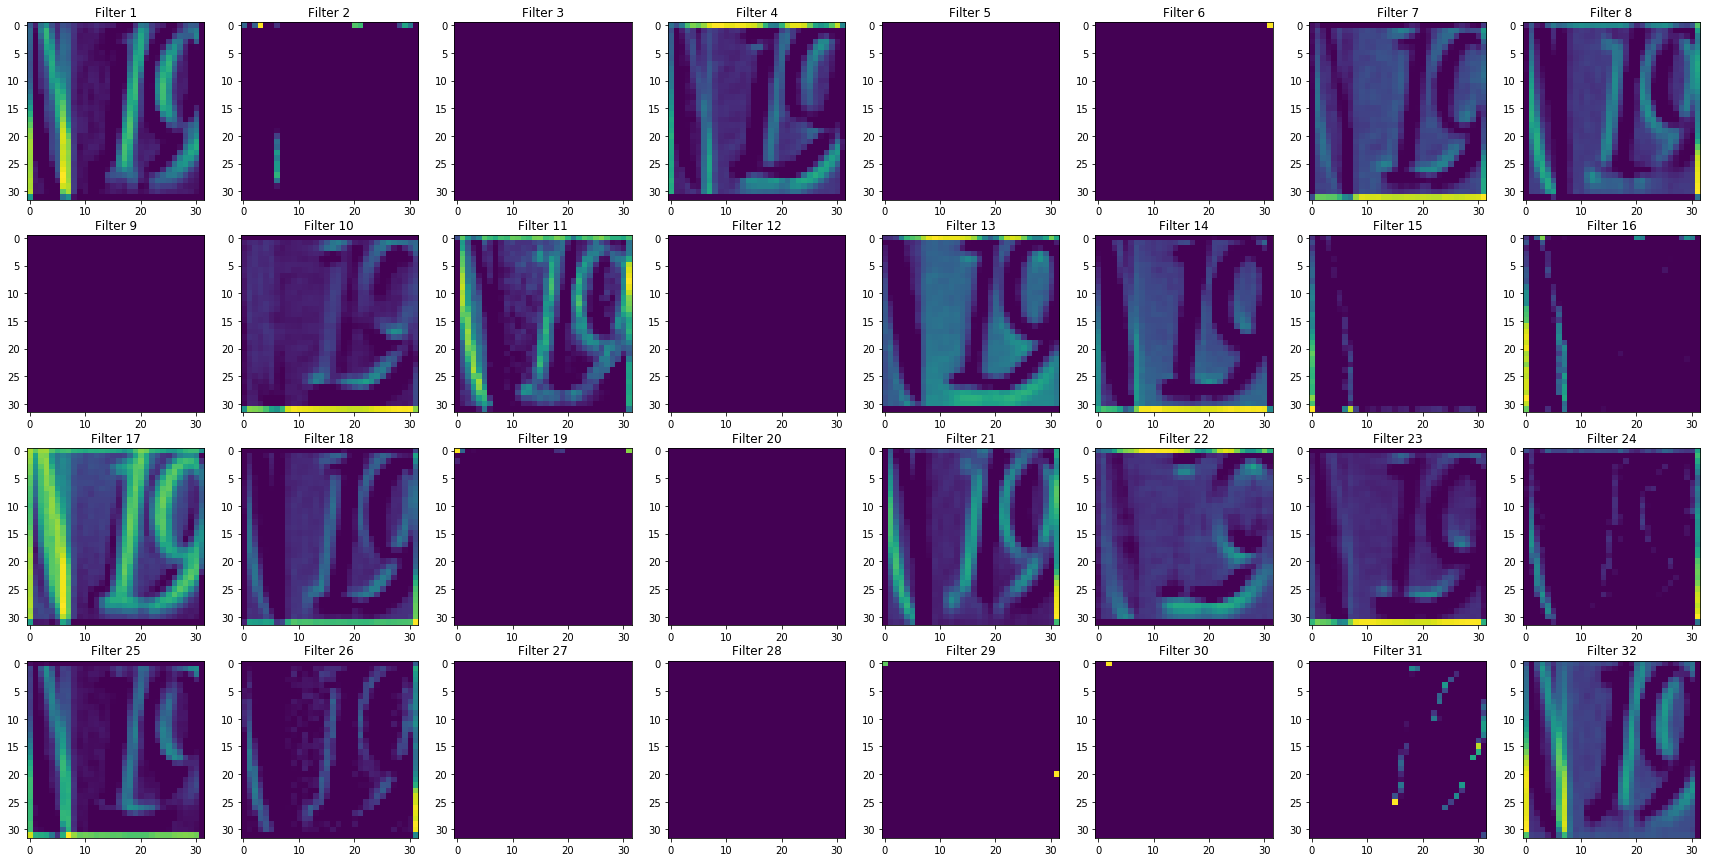

In [44]:
# The activation maps given by the filters in conv1. 
plt.figure(1, figsize=(30,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(layer_outs[1][0,:,:,i])

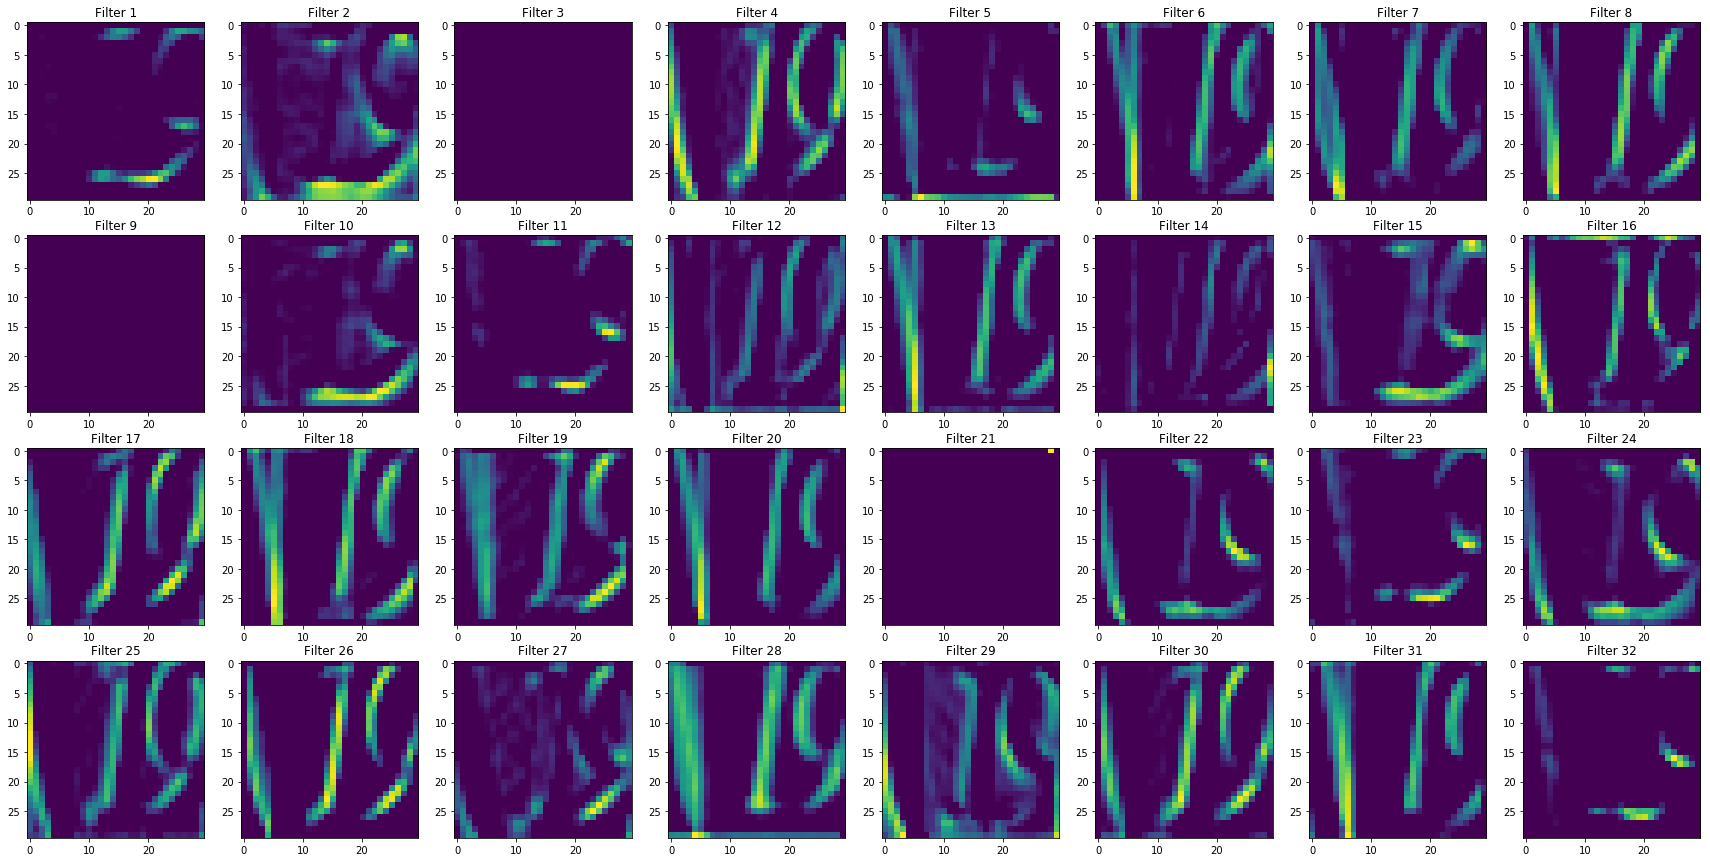

In [46]:
# The activation map given by the filters in conv2. 
plt.figure(1, figsize=(30,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(layer_outs[3][0,:,:,i])

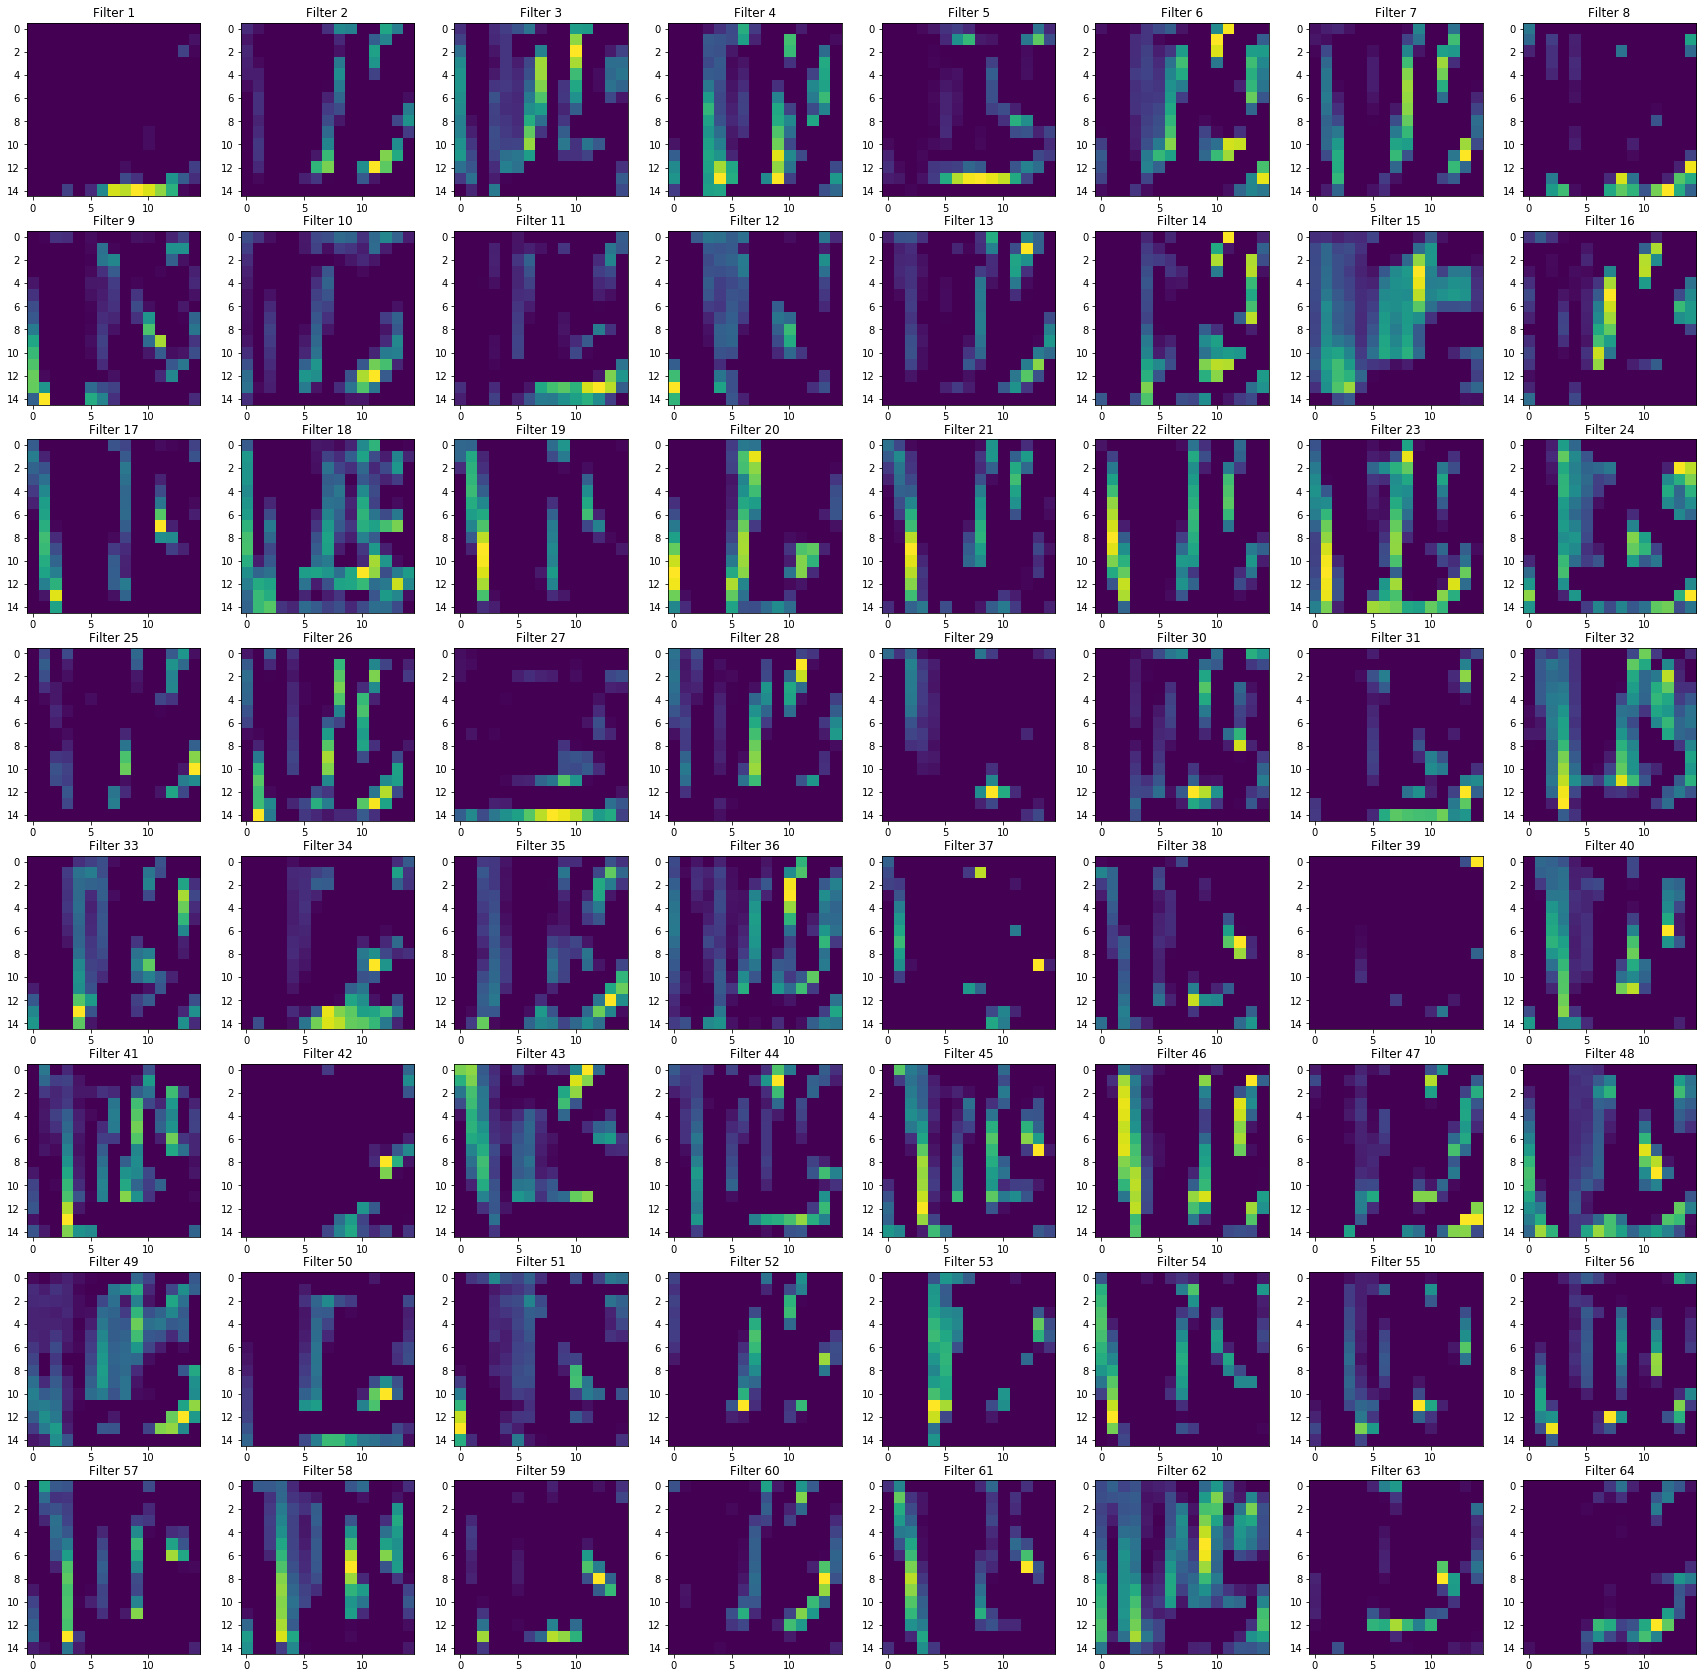

In [47]:
# The activation map given by the filters in conv3. 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(layer_outs[7][0,:,:,i])

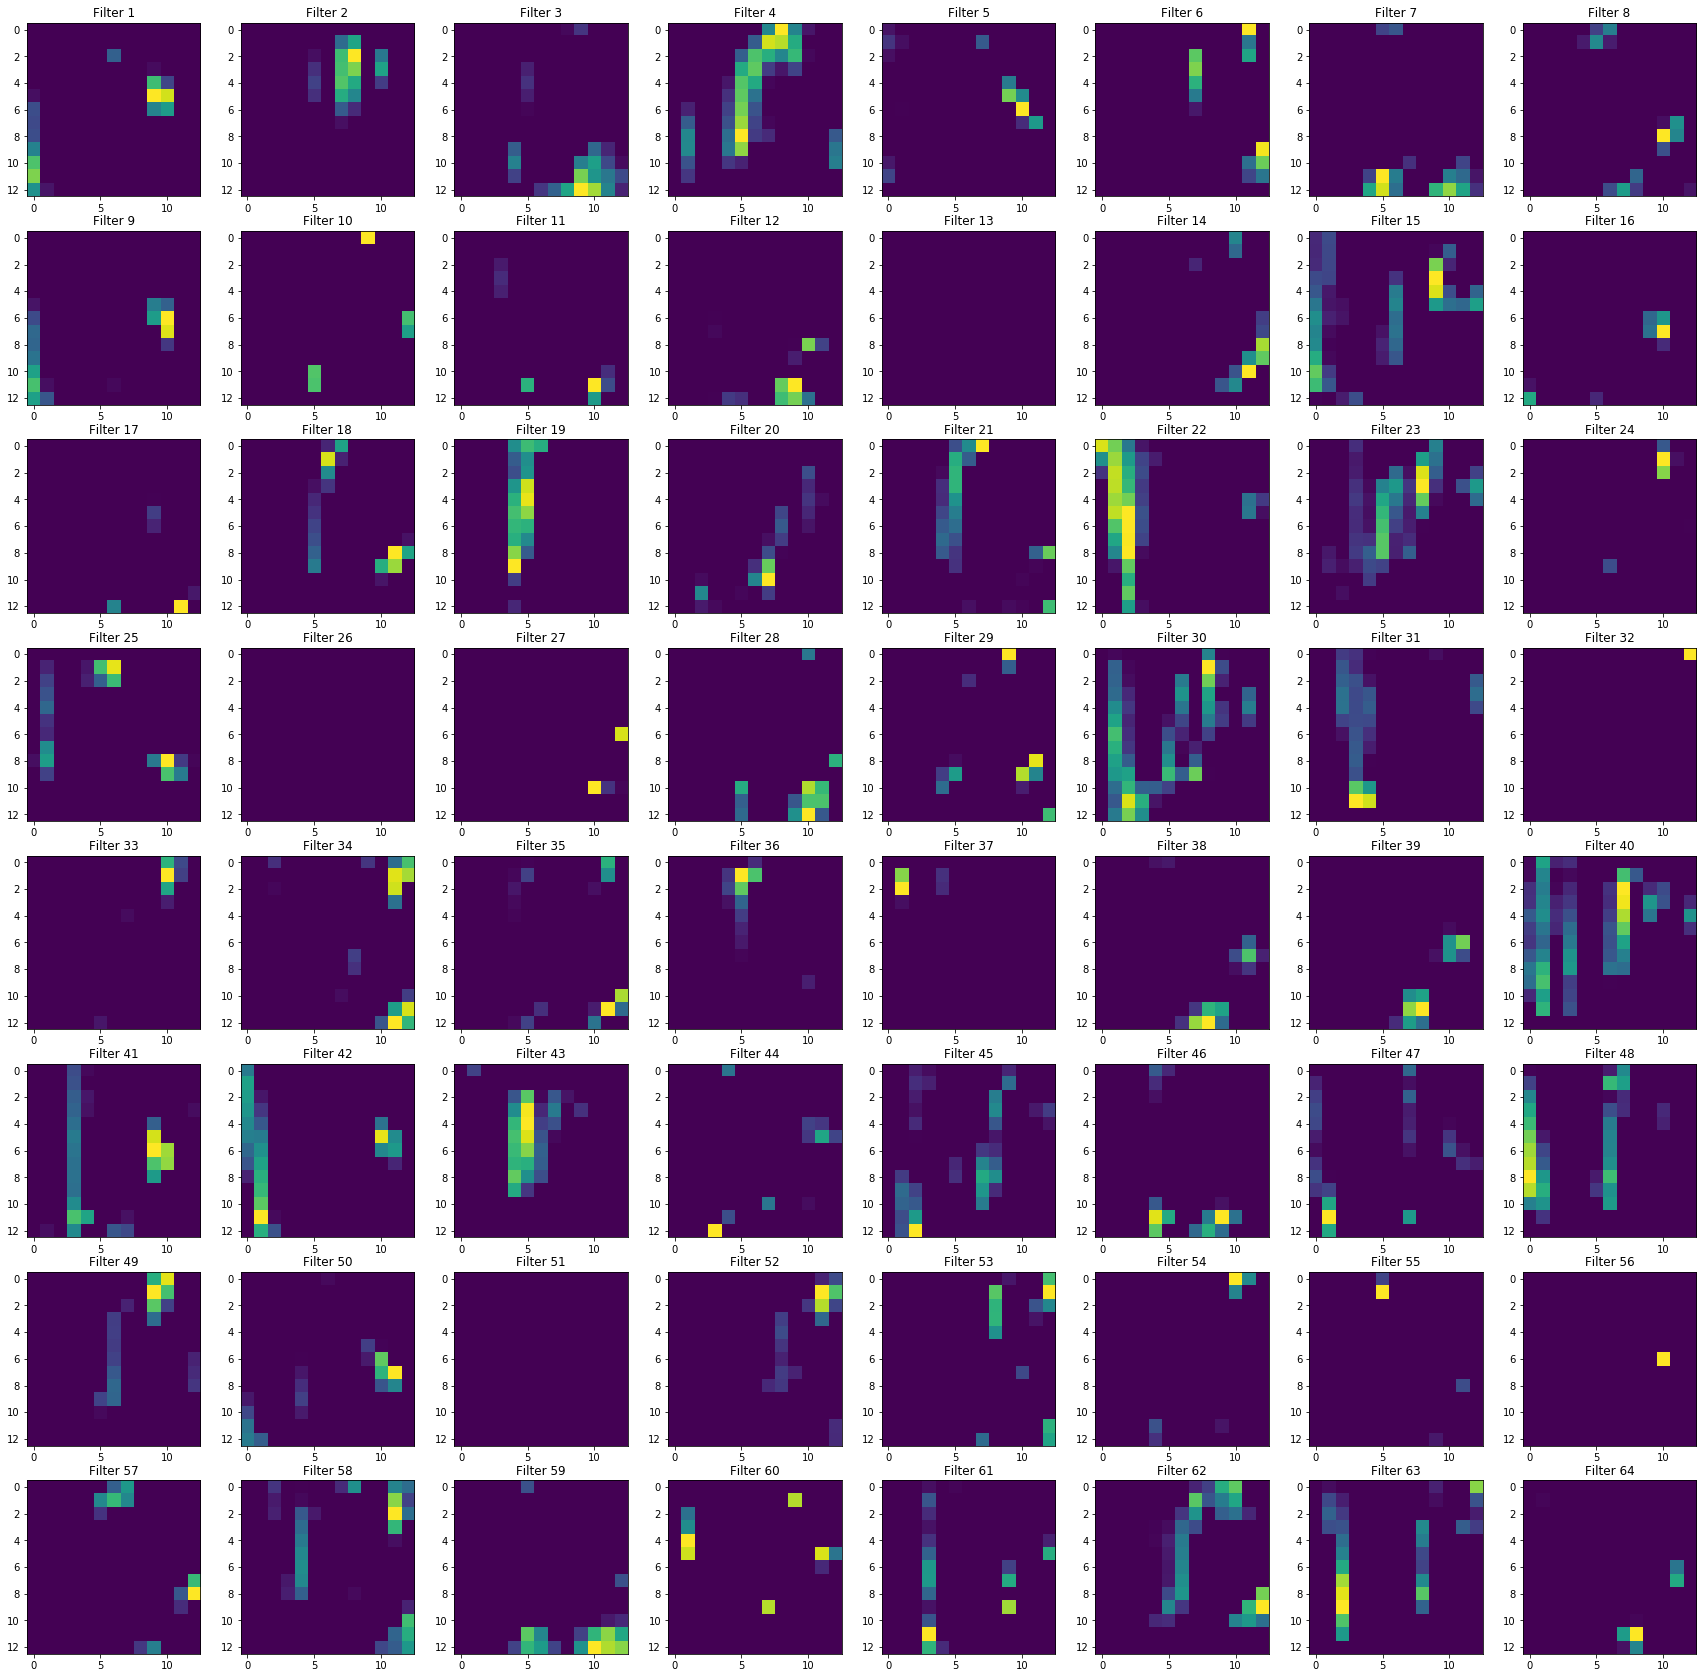

In [48]:
# The activation map given by the filters in conv4. 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(layer_outs[9][0,:,:,i])

In [33]:
input_img = model.input  # Placeholder

In [34]:
layer_dict = dict([(layer.name, layer) for layer in model.layers[0:]])  # Help us index different layers in the following steps.

In [35]:
def normalize(x):
    # utility function to normalize a tensor by its L2 norm
    return x / (K.sqrt(K.mean(K.square(x))) + K.epsilon())  

# The idea of normalizing gradient is from the post "How convolutional neural networks see the world".

In [36]:
def deprocess_image(x):
    # normalize tensor
    x -= x.mean()
    x /= (x.std() + K.epsilon())  # This function is from the post "How convolutional neural networks see the world".
    x *= 0.1
    x += 0.5
    x = np.clip(x, 0, 1)  # Limits the value of every pixel between 0 and 1
    return x

In [41]:
a = model.get_weights()
firstfilter = []
for i in range(32):
    firstfilter.append(a[0][:,:,:,i])

In [54]:
# Neruon
# Find an input image that maximaly activate the 64 filters in conv1.
kept_filters = []
idx = 1
for Filter in firstfilter:
    l1f1_in_tmp = []
    for color in Filter:
        col_tmp = []
        for row in color:
            row_tmp = []
            for entry in row:
                if entry >=0:
                    row_tmp.append(255)
                else:
                    row_tmp.append(0)
            col_tmp.append(row_tmp)    
        l1f1_in_tmp.append(col_tmp)
    idx = idx+1

    kept_filters.append((l1f1_in_tmp, idx))

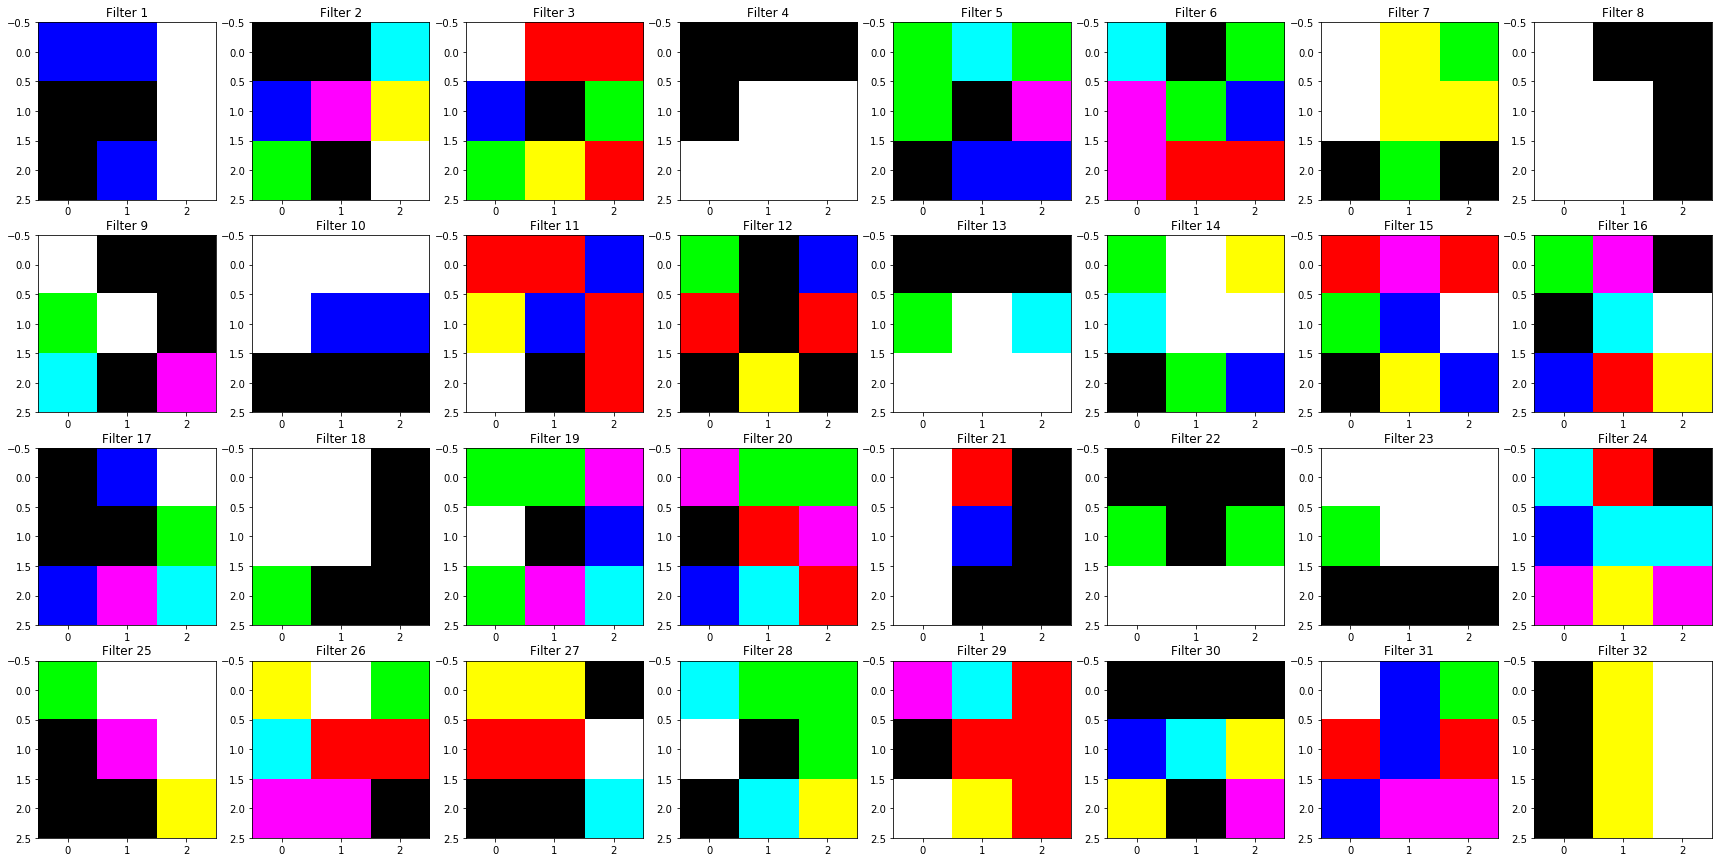

In [55]:
# Show the 64 images 
plt.figure(1, figsize=(30,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters[i][0])

In [64]:
secondfilter = []
for i in range(32):
    secondfilter.append(a[2][:,:,:,i])

In [65]:
secondfilter
# Cannot understand the structure of this layer

[array([[[-9.33001786e-02,  9.73877683e-03,  1.12805208e-02,
          -2.65994042e-01, -5.93961403e-02,  3.92938145e-02,
           9.72641110e-02, -1.06146947e-01,  7.70888999e-02,
           8.47381875e-02,  5.64938709e-02,  7.91550130e-02,
          -7.60710463e-02,  1.12025790e-01,  5.31294569e-02,
           6.61050454e-02, -2.93828566e-02,  2.12030411e-01,
           6.47214502e-02,  6.32734597e-03, -5.09647727e-02,
          -2.90626198e-01,  2.15530738e-01,  4.50408757e-02,
           6.04798943e-02, -5.25736846e-02, -9.02450681e-02,
           7.63664171e-02, -4.15507853e-02,  2.86321491e-02,
          -7.88528845e-02,  1.56870577e-02],
         [-7.41236582e-02, -9.51132178e-02, -7.92457163e-03,
          -1.75709635e-01,  6.46474734e-02, -6.56300560e-02,
           7.08917677e-02, -9.30674821e-02,  6.24238849e-02,
           2.59713948e-01, -4.13219742e-02, -2.30708048e-02,
          -1.03170872e-01,  3.44737507e-02,  6.44570589e-02,
          -5.57825193e-02,  4.34574746e-

In [73]:
# Find input images that maximaly activate the filters in conv1.
kept_filters_2 = []
for filter_index in range(32):
   
    layer_output = layer_dict['activation_1'].output
    loss = K.sum(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, input_img)[0]
    grads = normalize(grads)
    
    iterate = K.function([input_img], [loss, grads])
    step = 0.2
    
    input_img_data = np.random.random((1, 32, 32, 3))
    #input_img_data = (input_img_data - 0.5) * 20 + 128
    
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        if loss_value <= 0.:
            break
    
    img = deprocess_image(input_img_data[0])
    kept_filters_2.append((img, loss_value))


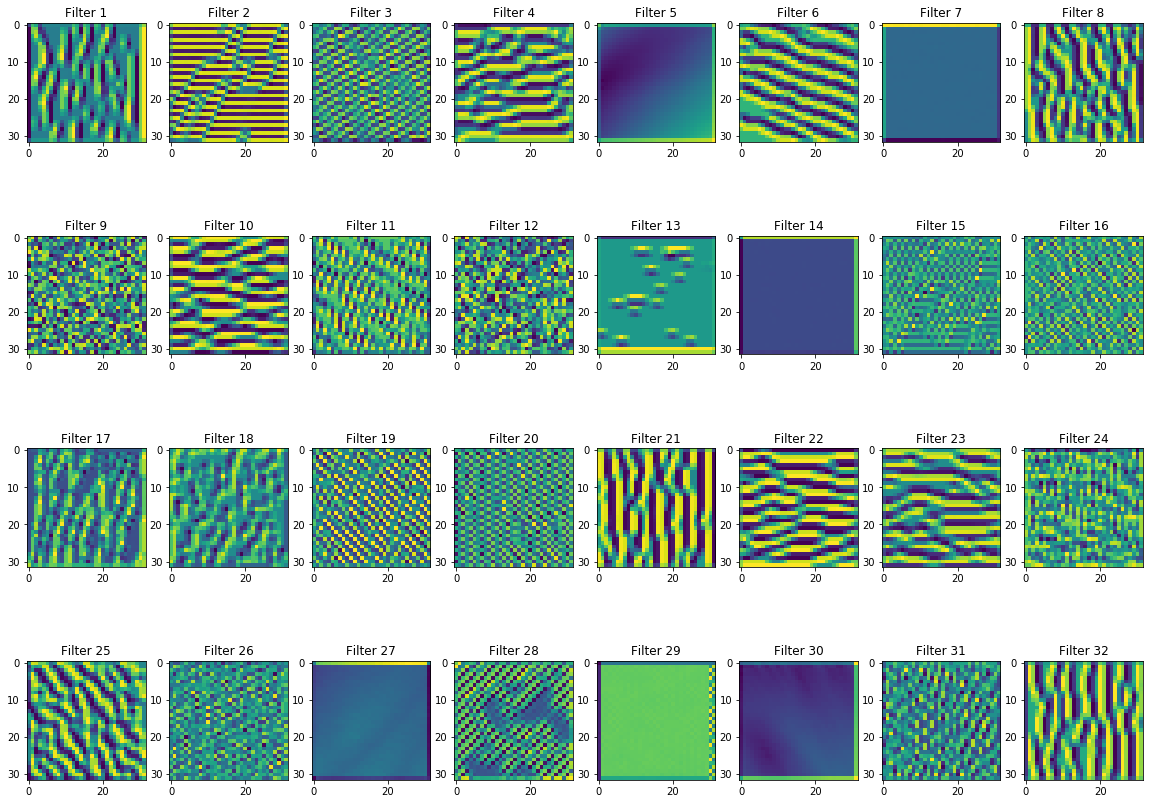

In [74]:
# Show the 32 images 
plt.figure(1, figsize=(20,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters_2[i][0][:,:,0].reshape(32,32))

In [83]:


# Find input images that maximaly activate the filters in conv1 with transformation.
kept_filters_2 = []
for filter_index in range(32):
   
    layer_output = layer_dict['activation_1'].output
    loss = K.sum(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, input_img)[0]
    grads = normalize(grads)
    
    iterate = K.function([input_img], [loss, grads])
    step = 0.2
    
    input_img_data = np.random.random((1, 32, 32, 3))
    #input_img_data = (input_img_data - 0.5) * 20 + 128
    
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        input_img_data = input_img_data.reshape(32,32,3)
        for row in input_img_data:
            for item in row:
                factor = np.random.uniform(-1,1)
                item = item + factor * 0.5
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rotate(input_img_data,factor*0.025)
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rescale(input_img_data,1.01**factor)
        input_img_data = skimage.transform.resize(input_img_data,(32,32,3))
        input_img_data = input_img_data.reshape(1,32,32,3)
        
        if loss_value <= 0.:
            break
    
    img = deprocess_image(input_img_data[0])
    kept_filters_2.append((img, loss_value))


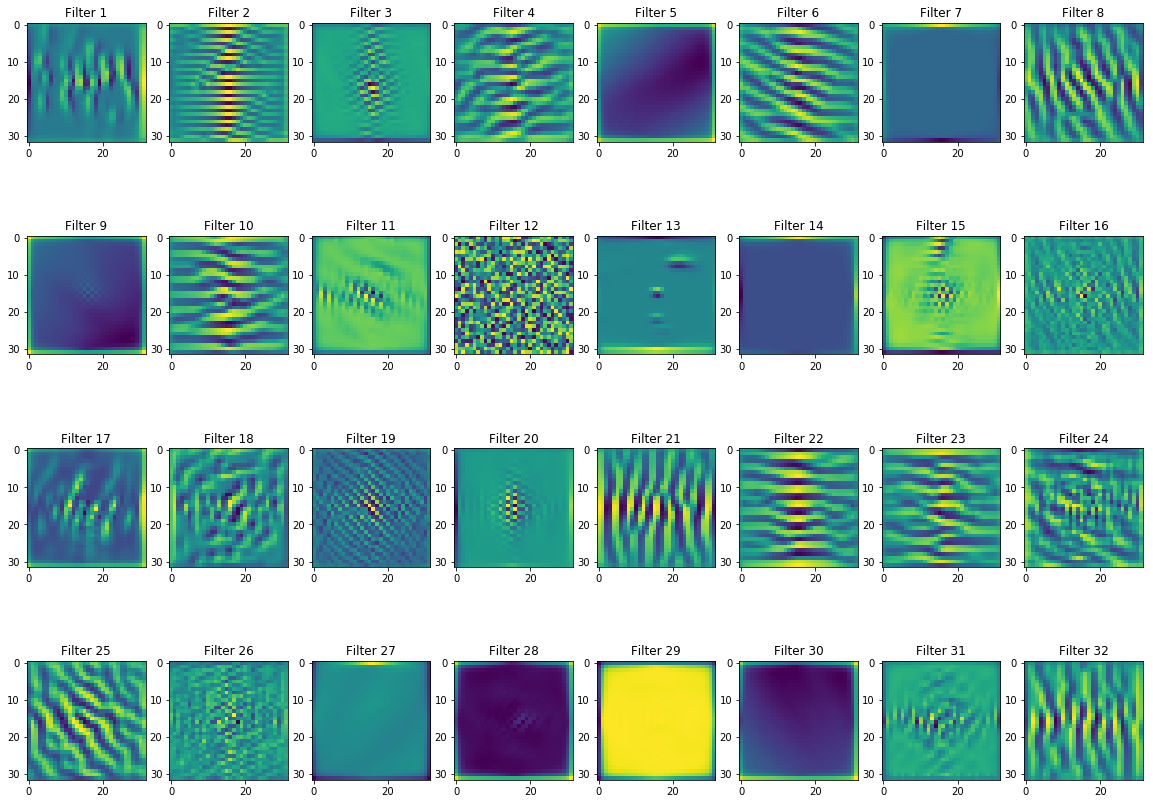

In [84]:
# Show the 32 images 
plt.figure(1, figsize=(20,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters_2[i][0][:,:,0].reshape(32,32))

In [79]:


# Find input images that maximaly activate the filters in conv2.
kept_filters_2 = []
for filter_index in range(32):
   
    layer_output = layer_dict['activation_2'].output
    loss = K.sum(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, input_img)[0]
    grads = normalize(grads)
    
    iterate = K.function([input_img], [loss, grads])
    step = 0.2
    
    input_img_data = np.random.random((1, 32, 32, 3))
    #input_img_data = (input_img_data - 0.5) * 20 + 128
    
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        if loss_value <= 0.:
            break
    
    img = deprocess_image(input_img_data[0])
    kept_filters_2.append((img, loss_value))


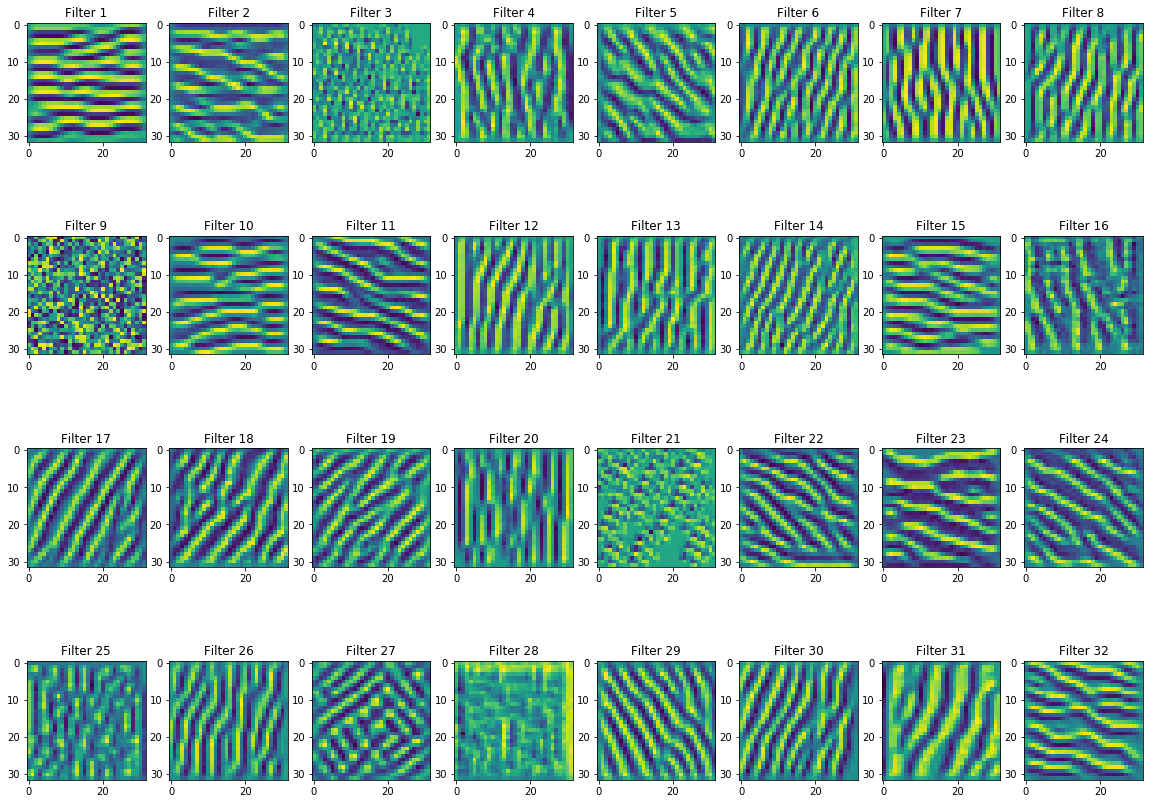

In [80]:
# Show the 32 images 
plt.figure(1, figsize=(20,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters_2[i][0][:,:,0].reshape(32,32))

In [85]:


# Find input images that maximaly activate the filters in conv2 transformation.
kept_filters_2 = []
for filter_index in range(32):
   
    layer_output = layer_dict['activation_2'].output
    loss = K.sum(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, input_img)[0]
    grads = normalize(grads)
    
    iterate = K.function([input_img], [loss, grads])
    step = 0.2
    
    input_img_data = np.random.random((1, 32, 32, 3))
    #input_img_data = (input_img_data - 0.5) * 20 + 128
    
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        input_img_data = input_img_data.reshape(32,32,3)
        for row in input_img_data:
            for item in row:
                factor = np.random.uniform(-1,1)
                item = item + factor * 0.5
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rotate(input_img_data,factor*0.025)
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rescale(input_img_data,1.01**factor)
        input_img_data = skimage.transform.resize(input_img_data,(32,32,3))
        input_img_data = input_img_data.reshape(1,32,32,3)
        
        if loss_value <= 0.:
            break
    
    img = deprocess_image(input_img_data[0])
    kept_filters_2.append((img, loss_value))


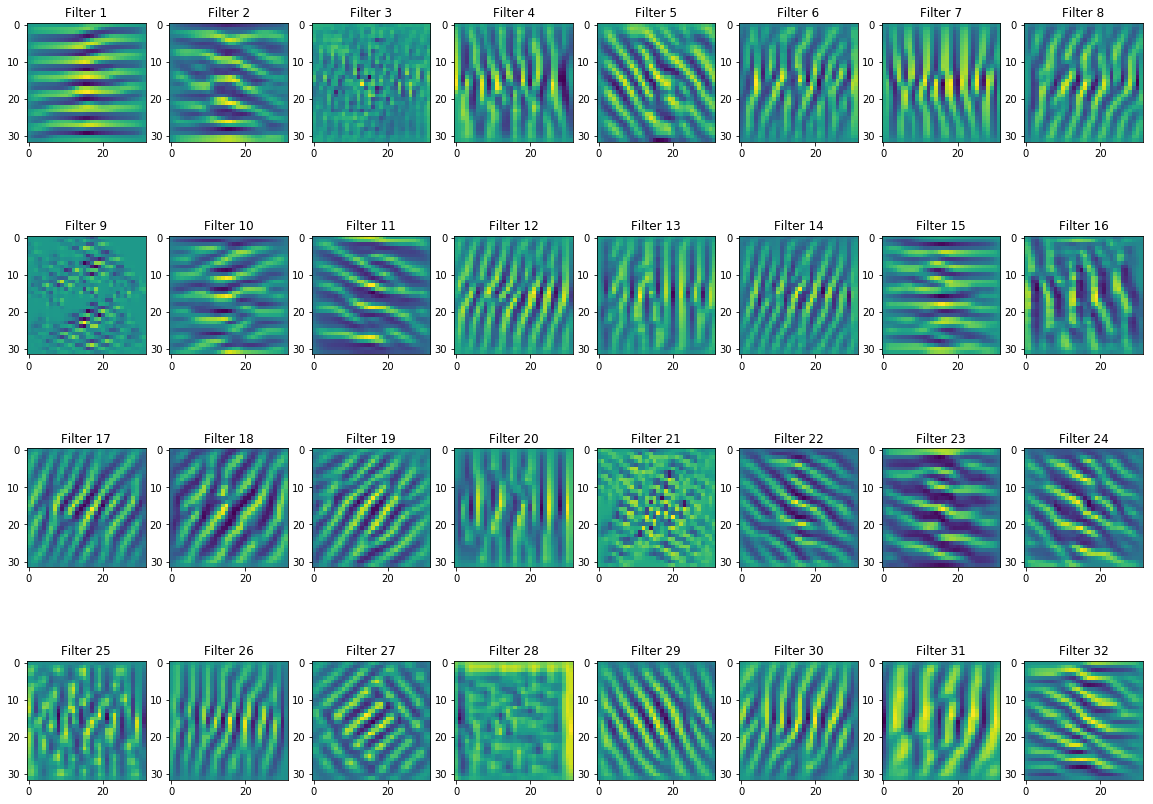

In [86]:
# Show the 32 images 
plt.figure(1, figsize=(20,15))
n_columns = 8
n_rows = 4
for i in range(32):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters_2[i][0][:,:,0].reshape(32,32))

In [91]:


# Find input images that maximaly activate the filters in conv3.
kept_filters_2 = []
for filter_index in range(64):
   
    layer_output = layer_dict['activation_3'].output
    loss = K.sum(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, input_img)[0]
    grads = normalize(grads)
    
    iterate = K.function([input_img], [loss, grads])
    step = 0.2
    
    input_img_data = np.random.random((1, 15, 15, 3))
    #input_img_data = (input_img_data - 0.5) * 20 + 128
    
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        if loss_value <= 0.:
            break
    
    img = deprocess_image(input_img_data[0])
    kept_filters_2.append((img, loss_value))


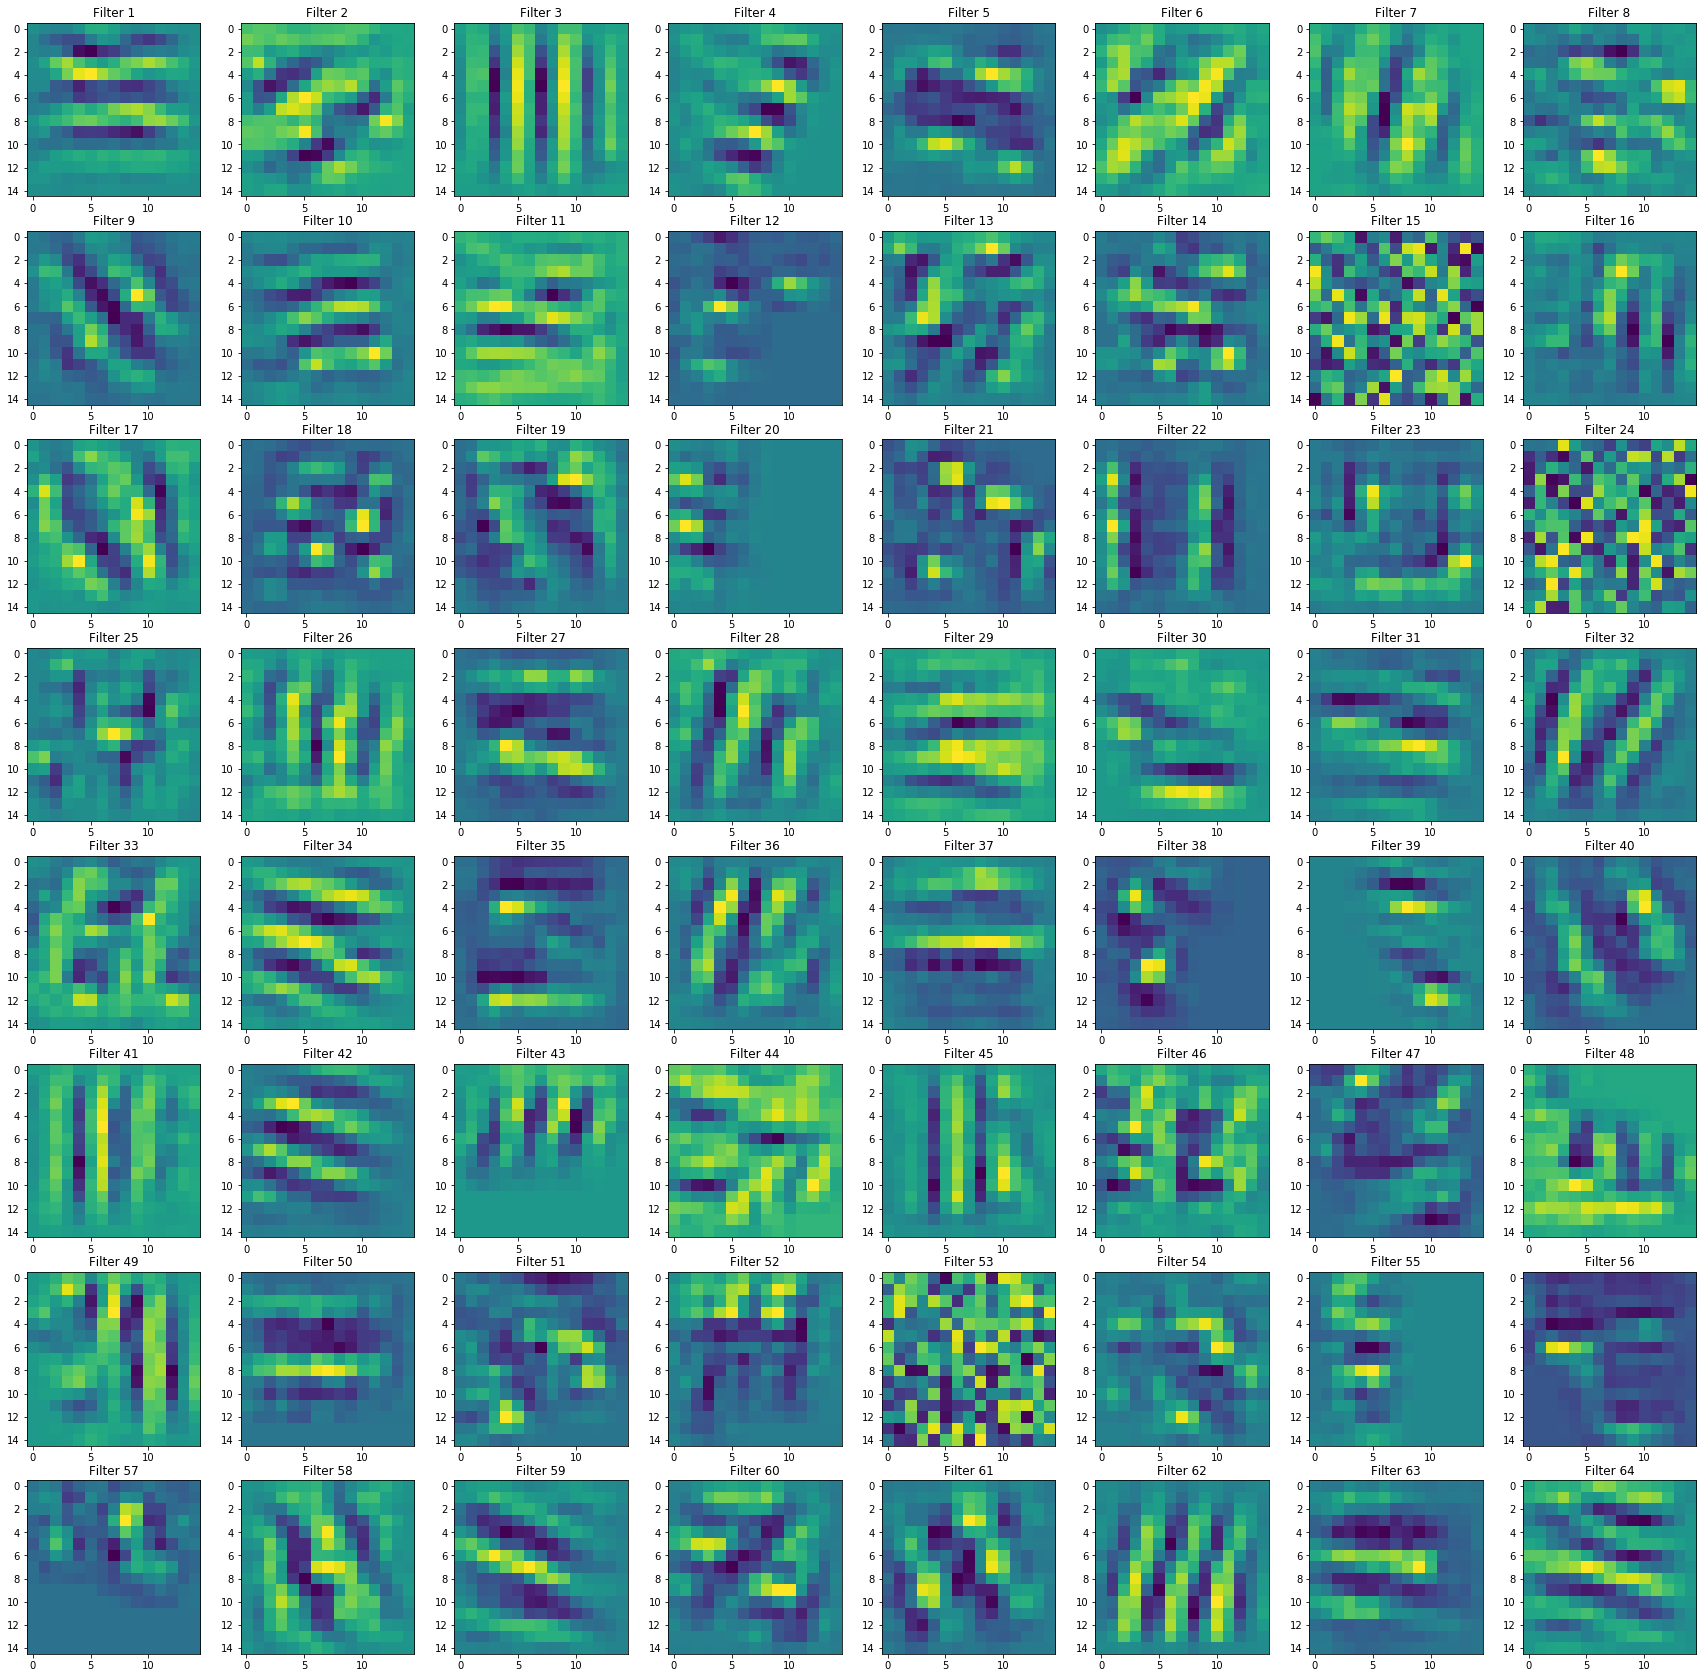

In [92]:
# Show the 64 images 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters_2[i][0][:,:,0].reshape(15,15))

In [89]:


# Find input images that maximaly activate the filters in conv3 transformation.
kept_filters_2 = []
for filter_index in range(64):
   
    layer_output = layer_dict['activation_3'].output
    loss = K.sum(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, input_img)[0]
    grads = normalize(grads)
    
    iterate = K.function([input_img], [loss, grads])
    step = 0.2
    
    input_img_data = np.random.random((1, 15, 15, 3))
    #input_img_data = (input_img_data - 0.5) * 20 + 128
    
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        input_img_data = input_img_data.reshape(15,15,3)
        for row in input_img_data:
            for item in row:
                factor = np.random.uniform(-1,1)
                item = item + factor * 0.5
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rotate(input_img_data,factor*0.025)
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rescale(input_img_data,1.01**factor)
        input_img_data = skimage.transform.resize(input_img_data,(15,15,3))
        input_img_data = input_img_data.reshape(1,15,15,3)
        
        if loss_value <= 0.:
            break
    
    img = deprocess_image(input_img_data[0])
    kept_filters_2.append((img, loss_value))


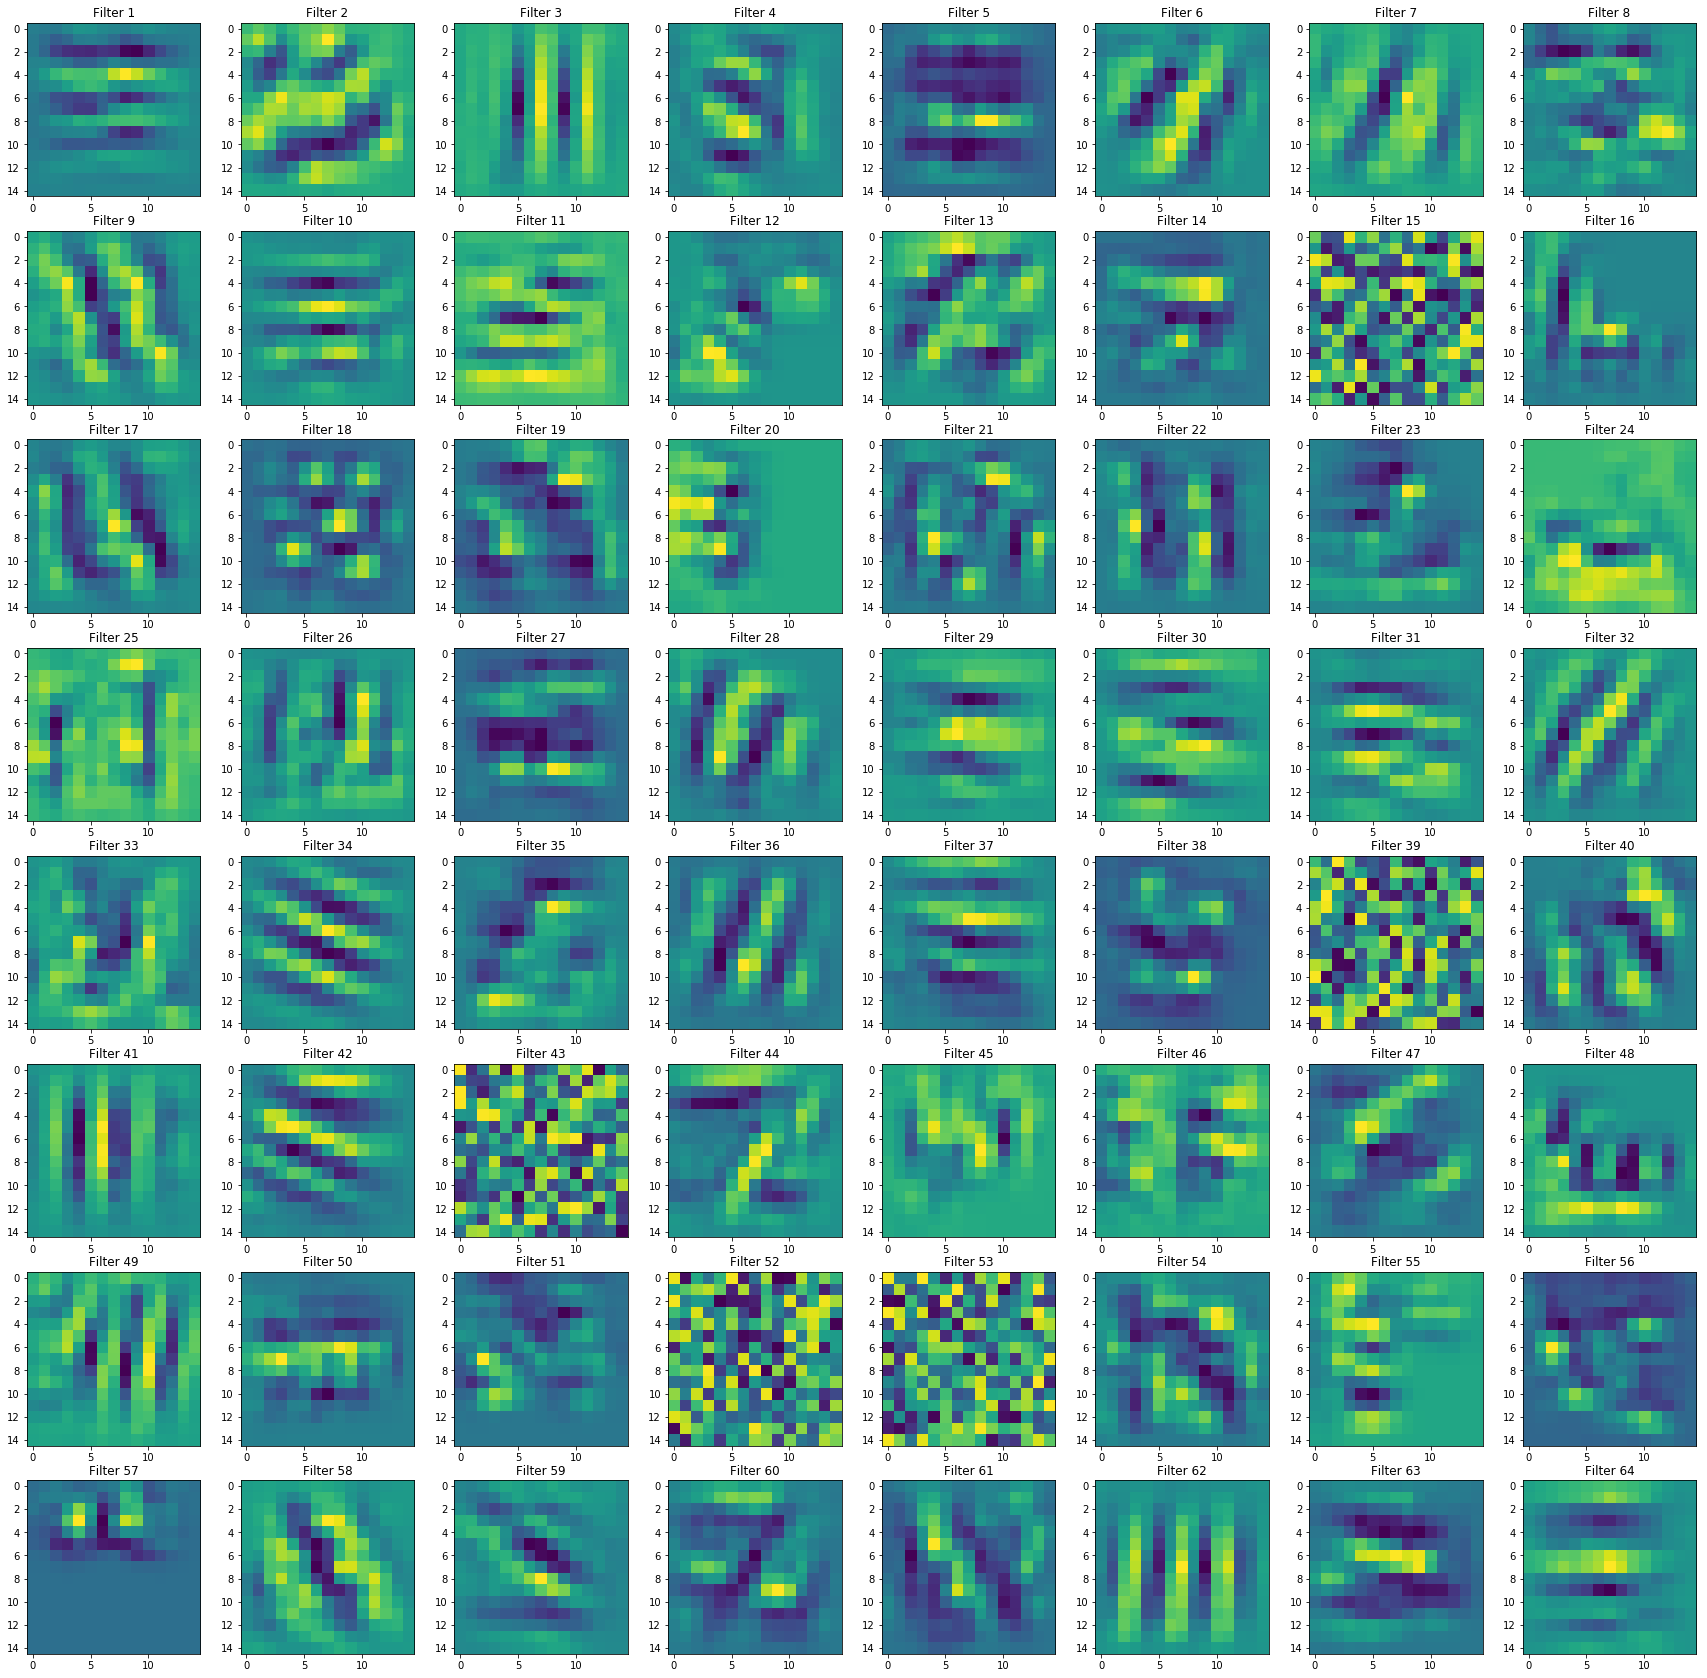

In [90]:
# Show the 64 images 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters_2[i][0][:,:,0].reshape(15,15))

In [93]:


# Find input images that maximaly activate the filters in conv4.
kept_filters_2 = []
for filter_index in range(64):
   
    layer_output = layer_dict['activation_4'].output
    loss = K.sum(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, input_img)[0]
    grads = normalize(grads)
    
    iterate = K.function([input_img], [loss, grads])
    step = 0.2
    
    input_img_data = np.random.random((1, 13, 13, 3))
    #input_img_data = (input_img_data - 0.5) * 20 + 128
    
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        
        if loss_value <= 0.:
            break
    
    img = deprocess_image(input_img_data[0])
    kept_filters_2.append((img, loss_value))


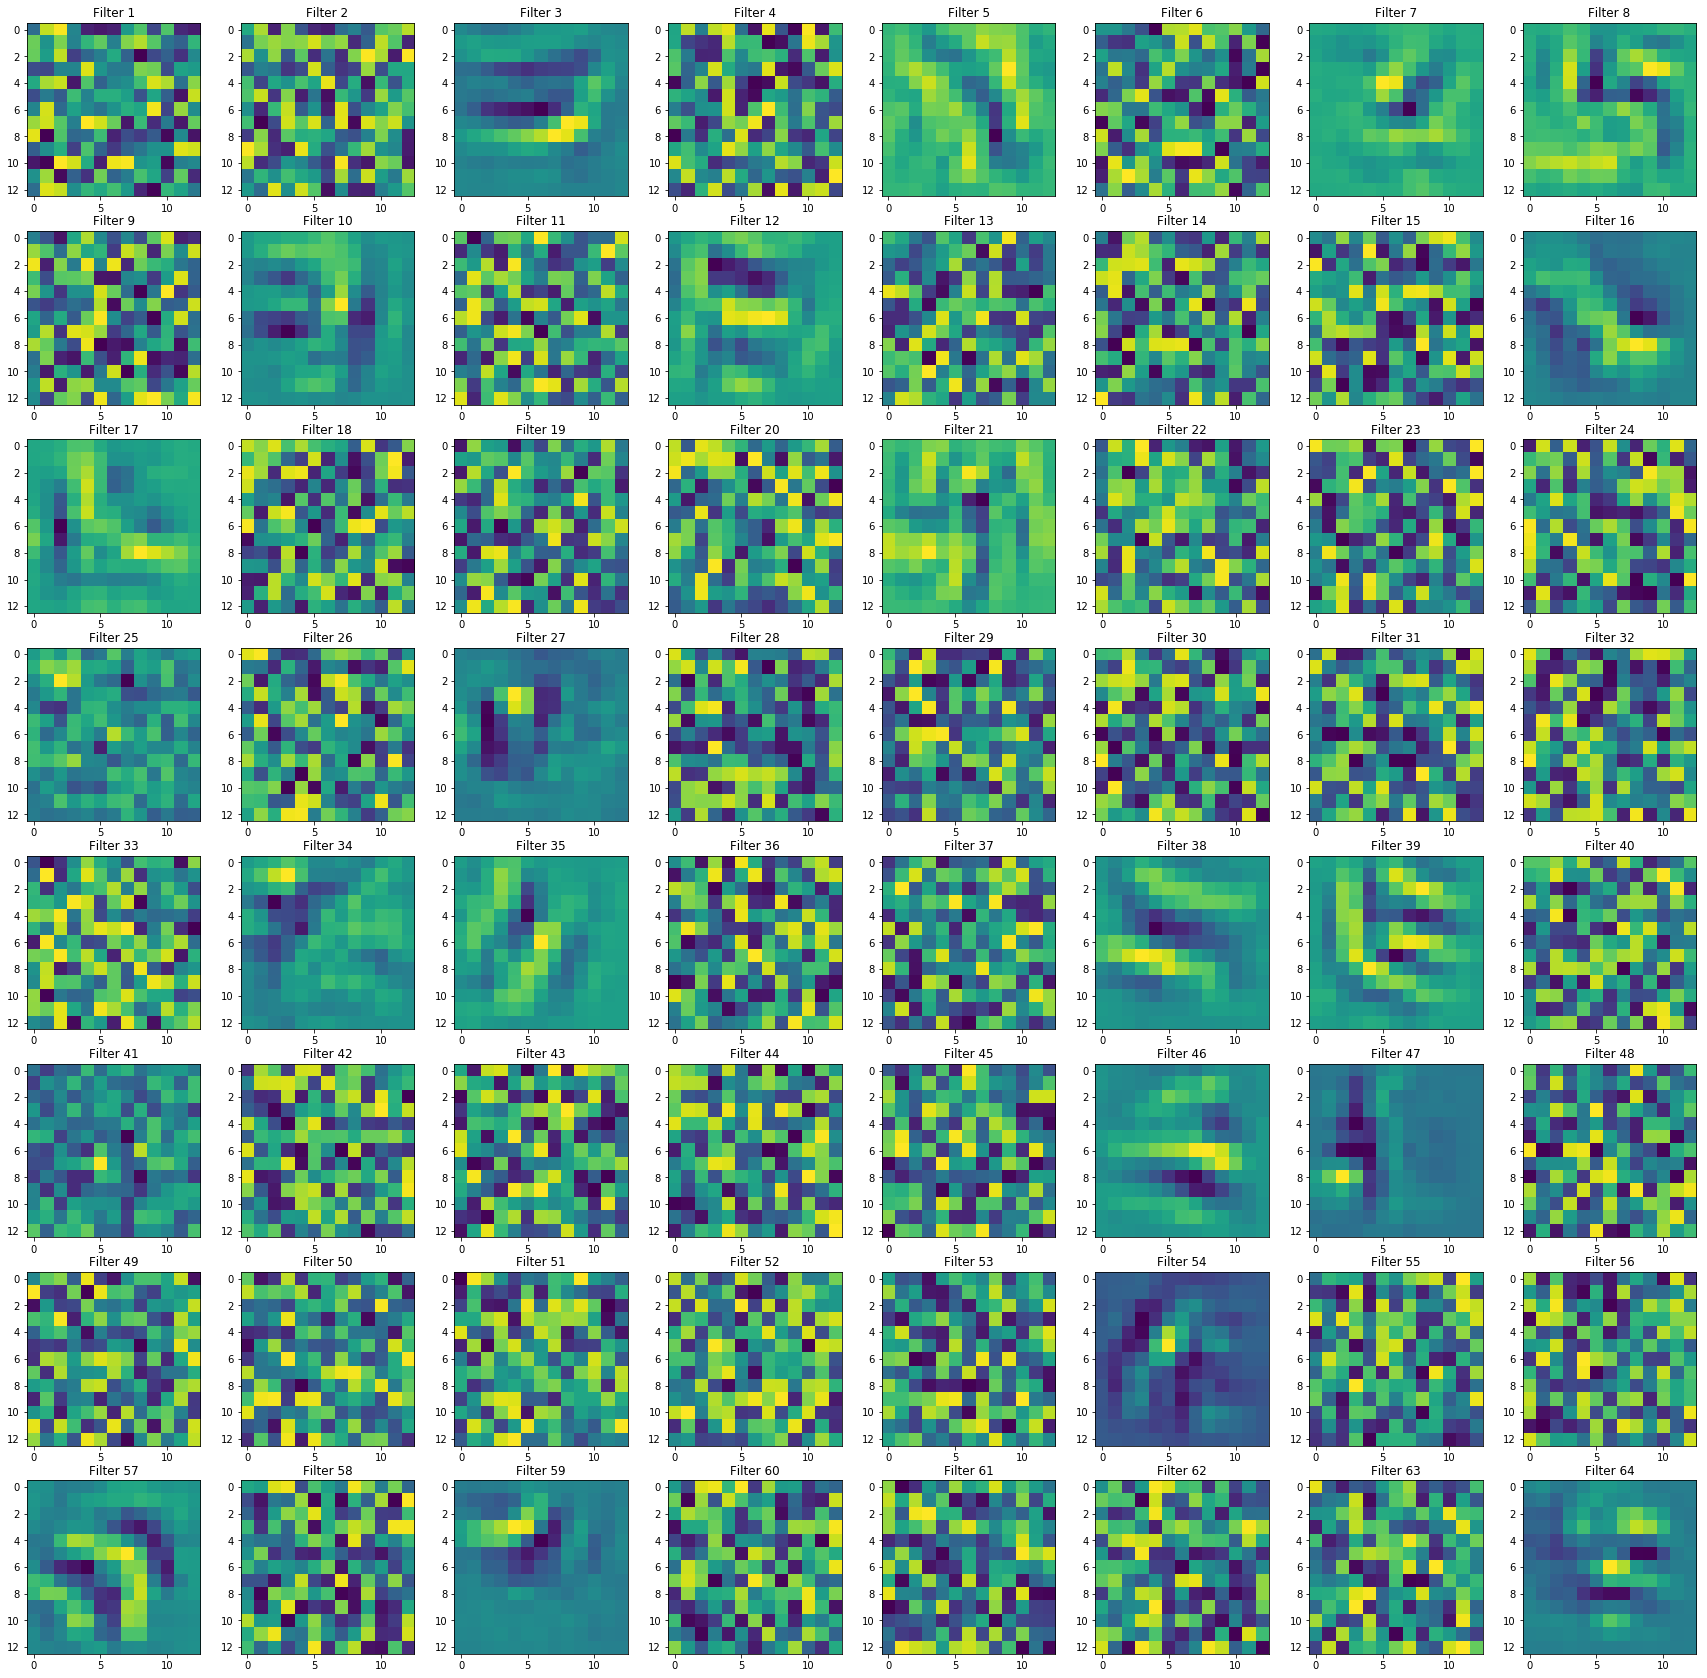

In [94]:
# Show the 64 images 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters_2[i][0][:,:,0].reshape(13,13))

In [95]:


# Find input images that maximaly activate the filters in conv4 transformation.
kept_filters_2 = []
for filter_index in range(64):
   
    layer_output = layer_dict['activation_4'].output
    loss = K.sum(layer_output[:, :, :, filter_index])
    grads = K.gradients(loss, input_img)[0]
    grads = normalize(grads)
    
    iterate = K.function([input_img], [loss, grads])
    step = 0.2
    
    input_img_data = np.random.random((1, 13, 13, 3))
    #input_img_data = (input_img_data - 0.5) * 20 + 128
    
    for i in range(1000):
        
        loss_value, grads_value = iterate([input_img_data])
        input_img_data += grads_value * step
        input_img_data = input_img_data.reshape(13,13,3)
        for row in input_img_data:
            for item in row:
                factor = np.random.uniform(-1,1)
                item = item + factor * 0.5
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rotate(input_img_data,factor*0.025)
        factor = np.random.uniform(-1,1)
        input_img_data = skimage.transform.rescale(input_img_data,1.01**factor)
        input_img_data = skimage.transform.resize(input_img_data,(13,13,3))
        input_img_data = input_img_data.reshape(1,13,13,3)
        
        if loss_value <= 0.:
            break
    
    img = deprocess_image(input_img_data[0])
    kept_filters_2.append((img, loss_value))


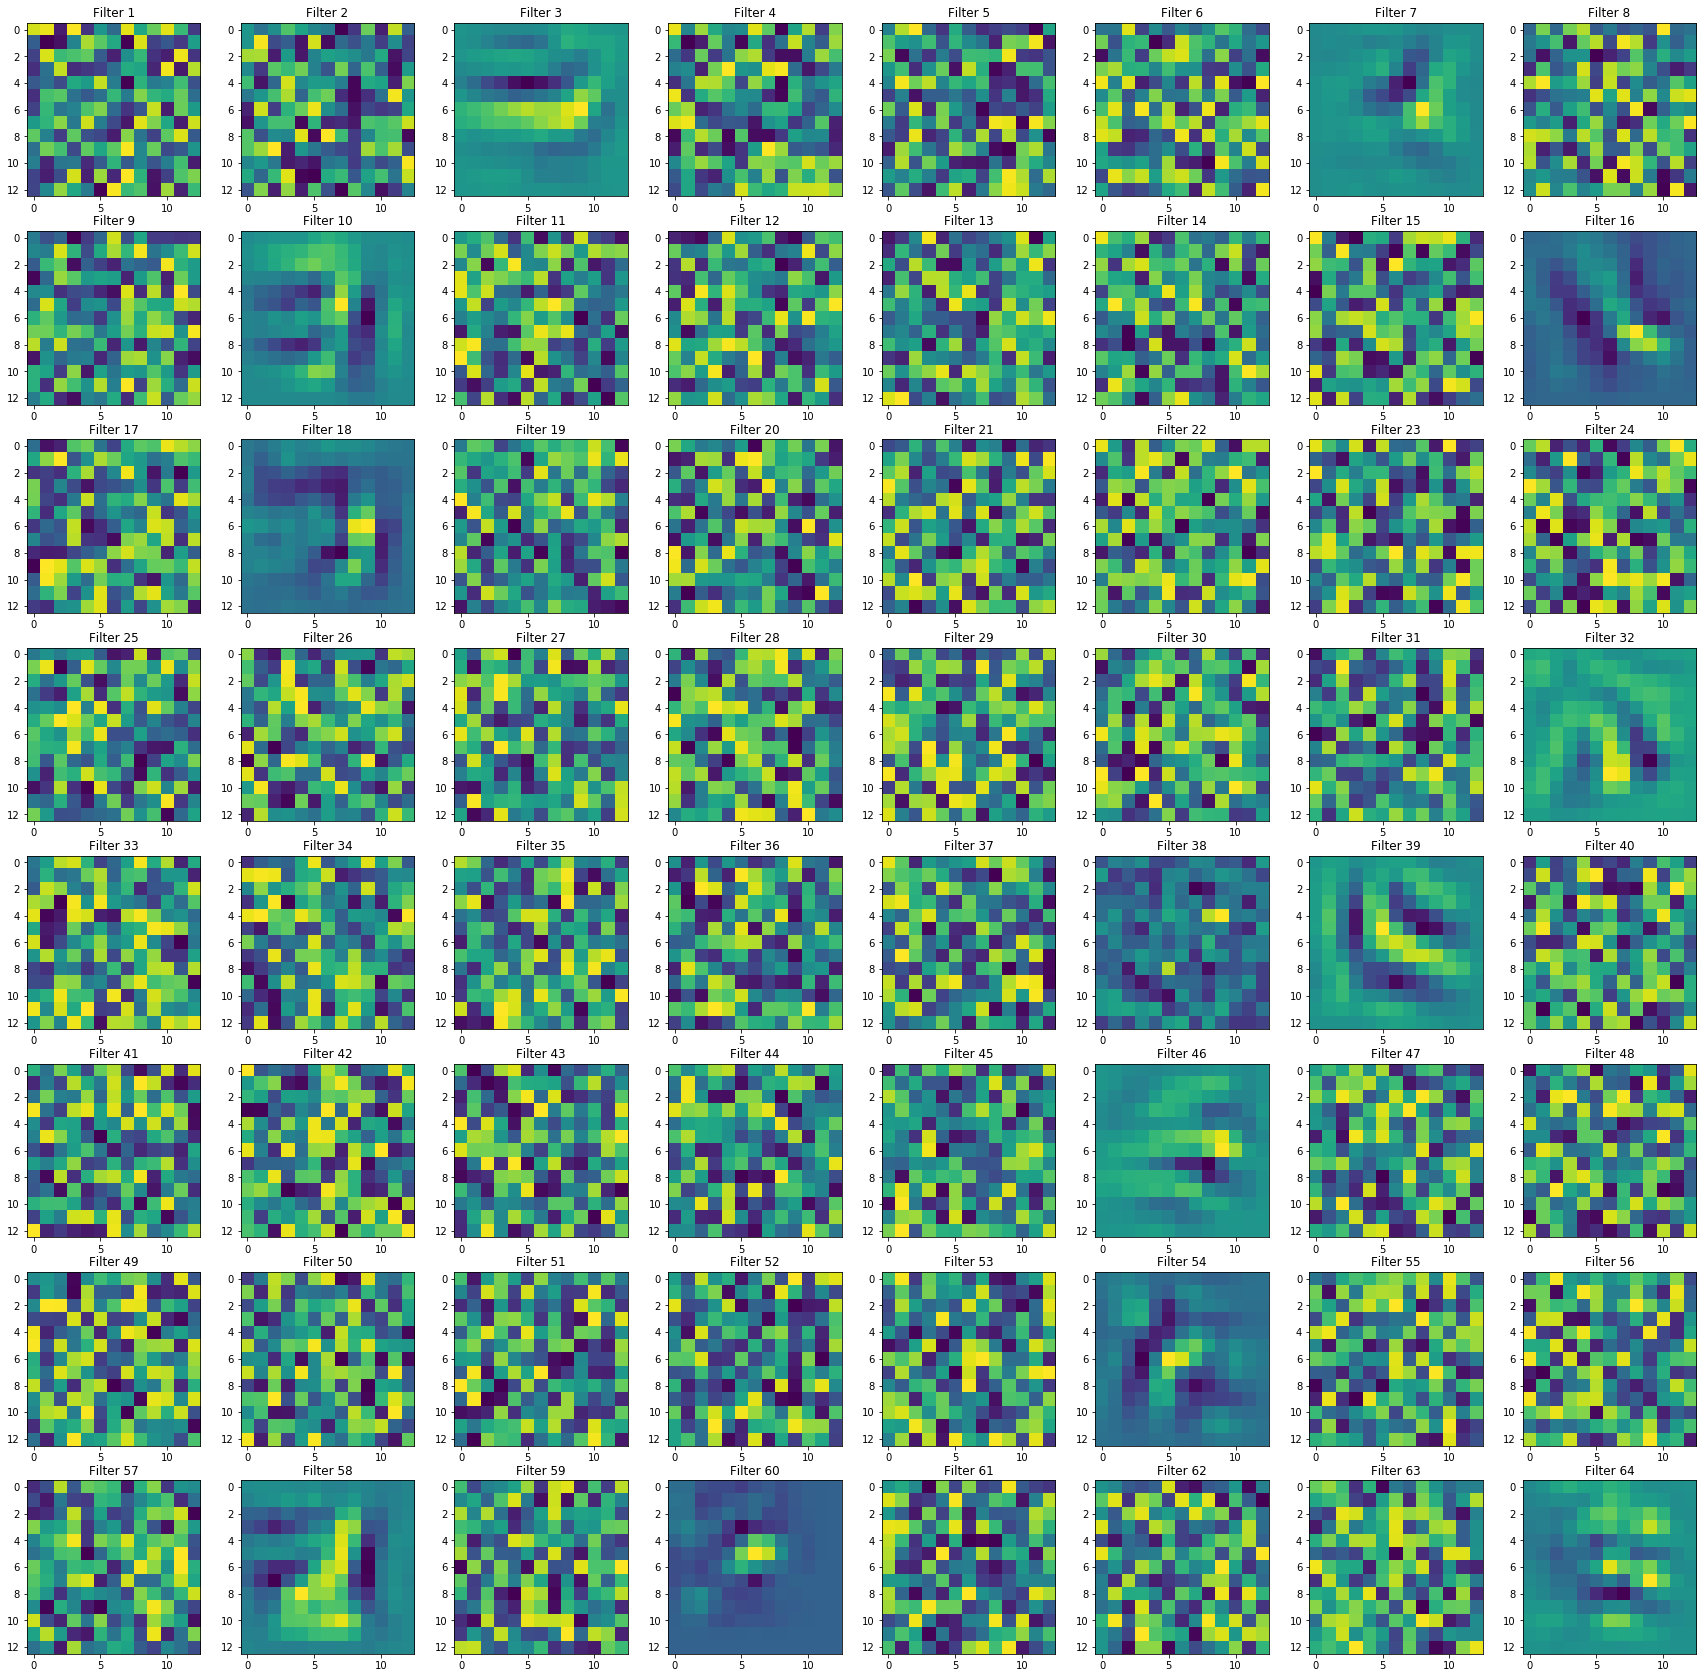

In [96]:
# Show the 64 images 
plt.figure(1, figsize=(30,30))
n_columns = 8
n_rows = 8
for i in range(64):
    plt.subplot(n_rows, n_columns, i+1)
    plt.title('Filter ' + str(i+1))
    plt.imshow(kept_filters_2[i][0][:,:,0].reshape(13,13))